# Marlow Case - TripleTen DS Course - Final Project
# Churn Prediction: Identifying At-Risk Customers for Interconnect's Retention Strategies
---

# Table of Contents
<a id='contents'></a>

- [1. Introduction](#intro)
    - Purpose
    - Services Summary
    - Challenges
    - Objectives
- [2. Initializations](#init)
- [3. Data Exploration](#explore)
    - [3.1 Contract](#con)
    - [3.2 Internet](#internet)
    - [3.3 Personal](#pers)
    - [3.4 Phone](#phone)
    - [3.5 Conclusion](#exp_conclude)
- [4. Data Preprocessing](#pp)
    - [4.1 Merging the Datasets](#merge)
    - [4.2 Implementing Data Fixes](#fixes)
    - [4.3 Feature Engineering](#eng)
        - Tenure
        - Service Types
        - Number of Internet Services
        - Payment Method Reduction
        - Quarters
- [5. Exploratory Data Analysis](#EDA)
    - [5.1 Numerical Features](#num_feats)
    - [5.2 Categorical Features](#cat_feats)
        - [5.2.1 Chi-Squared Tests](#chi_test)
    - [5.3 Distribution of the Target Class](#targ_dist)
    - [5.4 Monthly Payments](#month_pay)
    - [5.5 Percentages of Clients by Service Type](#serv_type)
    - [5.6 Client Inflow and Outflow](#in+out)
    - [5.7 Correlation Matrix](#corr)
    - [5.8 Conclusion](#eda_summ)
- [Appendix A: Saving Models](#apx_A)
- [Appendix B: Preprocessing Notes](#apx_B)
- [Appendix C: Work Plan](#the_plan)
- [Appendix D: Challenges Faced](#challenges)

# 1. Introduction
<a id='intro'></a>

---

## 1.1 Purpose

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts. 

## 1.2 Services Summary

Interconnect provides two types of services:

1. **Landline communication:** The telephone can be connected to several lines simultaneously.
2. **Internet:** The network can be set up via a `telephone line` (DSL, digital subscriber line) or through a `fiber optic cable`.
    - Antivirus Software (*DeviceProtection*)
    - Malicious Website Blocker (*OnlineSecurity*)
    - Technical Support (*TechSupport*)
    - Cloud Storage and Data Backup Services (*OnlineBackup*)
    - TV Streaming (*StreamingTV*)
    - Movie Directory (*StreamingMovies*)

The clients can choose between a `monthly payment plan` or a `1-year or 2-year contract`.

## 1.3 Challenges

From the description, Interconnect faces two key challenges in addressing customer churn predictions:

1. What are the common traits or patterns among clients who have left?
2. How accurately can customer churn be predicted using machine learning models?

## 1.4 Objectives

1. Identify the characteristics or behaviors that distinguish between active clients and those who are at-risk, enabling proactive intervention strategies.
2. Develop a machine learning model with an **AUC-ROC score of at least 0.85**.

## 1.5 ML Optimization
In previous projects I have always stuck to one method of optimization. In this project I will be combining methods. Each Machine Learning model will be optimized on a wide parameter grid using Bayesian optimization and then further searched with a smaller parameter grid based on the bayesian optimization using GridSearch.

[Back to Contents](#contents)

# 2. Initializations
<a id='init'></a>

---

In [1]:
import pandas as pd
import numpy as np
import math
import inflection

# load models
from joblib import dump, load

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# ML prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ML metrics
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

# ML models - may need more for the stack
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, HistGradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf

# will need more from tf for keras; will wait till building NN

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure matplotlib
%config InlineBackend.figure_format = 'retina'

In [3]:
# remove column limit
pd.set_option("display.max_columns", None)

[Back to Contents](#contents)

# 3. Data Exploration
<a id='explore'></a>

---
The following functions will aid in the automation of tasks in this section. 

In [4]:
def info_samp_shape(df, n = 5):
    '''
    Function to output n sample rows and the shape of the 
    given DataFrame. 
    Input parameter must be a DataFrame. 
    '''
    # Observe info
    print('\033[1m' + "Info Statement:" + '\033[0m')
    display(df.info())
    print('-'*46, '\n')
    
    # Observe the df
    print('\033[1m' + "Sample Rows:" + '\033[0m')
    display(df.sample(n, random_state=42))
    print('-'*140, '\n')

    # Observe shape
    print('\033[1m' + "Shape:" + '\033[0m')
    display(df.shape)
    print('-'*9, '\n')

In [5]:
def simple_explore(df):
    '''
    Function that applies basic pandas methods to perform data analysis
    on the given DataFrame. The function will return the number of duplicates, 
    the number of missing values, and a describe statement.
    Input must be a DataFrame. 
    '''

    # Observe duplicates
    print('\033[1m' + "Duplicate Rows:" + '\033[0m')
    display(df.duplicated().sum())
    print('-'*15, '\n')

    # Observe null values
    print('\033[1m' + "Null Values:" + '\033[0m')
    display(df.isna().sum())
    print('-'*22, '\n')

    # Observe describe
    print('\033[1m' + "DataFrame Description:" + '\033[0m')
    display(df.describe(include = 'all'))
    print('-'*130)

The provided data consits of files obtained from different sources:

- `contract.csv` - contract information
- `personal.csv` - the client's personal data
- `internet.csv` - information about internet services
- `phone.csv`    - information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client. 

For each column of each dataset, it is important to consider the following:
- Type of data
- % of missing values
- Noisiness level
    - Standard Deviation Analysis
    - Signal-to-Noise Ratio
    - Correlation to Target
- Relevance
- Type of distribution

Let's begin the investigation by loading the datasets. 

In [6]:
# load the datasets
filepath = r"C:\Users\marlo\OneDrive\Desktop\Python_Work\TripleTen_Lessons\Sprint_17_Project"

try:
    df_con = pd.read_csv(f"{filepath}\\contract.csv")
    df_int = pd.read_csv(f"{filepath}\\internet.csv")
    df_per = pd.read_csv(f"{filepath}\\personal.csv")
    df_pho = pd.read_csv(f"{filepath}\\phone.csv")
except:
    df_con = pd.read_csv("/datasets/contract.csv")
    df_int = pd.read_csv("/datasets/internet.csv")
    df_per = pd.read_csv("/datasets/personal.csv")
    df_pho = pd.read_csv("/datasets/phone.csv")

print('Datasets loaded successfully.')

Datasets loaded successfully.


=================================================================================================================

## 3.1 Contract
<a id='con'></a>

In [7]:
info_samp_shape(df_con)

Info Statement:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

---------------------------------------------- 

Sample Rows:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
185,1024-GUALD,2019-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,24.80,24.8
2715,0484-JPBRU,2016-09-01,No,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45
3825,3620-EHIMZ,2015-10-01,No,Two year,No,Mailed check,19.35,1031.7
1807,6910-HADCM,2019-09-01,2019-10-01 00:00:00,Month-to-month,No,Electronic check,76.35,76.35
132,8587-XYZSF,2014-07-01,No,Two year,No,Bank transfer (automatic),50.55,3260.1


-------------------------------------------------------------------------------------------------------------------------------------------- 

Shape:


(7043, 8)

--------- 



In the `contract` dataset there are 7043 rows and 8 columns detailing the client's contract information. 

**Data Description**
- `customerID`: A unique identifier for the client
- `BeginDate`: The date when the client started using our services.
- `EndDate`: The date the client terminated their existing contract.
    - A value of **No** indicates that the client is still using our services (_is an active client_).
- `Type`: The contract's payment subscription (_monthly, annually, bi-annually_).
- `PaperlessBilling`: Binary flag field describing whether the client is subscribed to digital billing.
- `PaymentMethod`: The method of payment for the subscribed services (_Eletronic Check, Mailed Check, etc._).
- `MonthlyCharges`: The amount charged to the client on a monthly basis.
- `TotalCharges`: The amount charged to the client over the lifespan of their subscription.

**Issues for Preprocessing:**
- The column labels are currently in pascal case and need to be **converted to snake case**.
- The `EndDate` column contains non-date values and therefore need to be replaced with a more appropriate value.
    - We will first replace the `No` values with `None` and then convert to datetime.
    - `BeginDate` also needs to be converted to datetime.

**Other Issues to Explore:**
- `TotalCharges` is an object datatype and not a float64. This implies there are non-numeric values present in the column and further exploration will be required.
- *We don't have clarification on `MonthlyCharges` or `TotalCharges`, additional investigation may be required to understand these columns.* 

**Feature Engineering Possibilities**
- Tenure for years, months, and days
- Creating a dedicated `active` or `churned` column --> binary flag indicating if the client is active or has churned

In [8]:
simple_explore(df_con)

Duplicate Rows:


0

--------------- 

Null Values:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

---------------------- 

DataFrame Description:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


----------------------------------------------------------------------------------------------------------------------------------


According to the outputs, there are no duplicate customers and although no null values in `TotalCharges`, the describe output says otherwise. There is clearly a blank value that occurs in 11 of the rows in this dataset, and this may be the cause of the object datatype. 

Also, the Coefficient of Variation on `MonthlyCharges` is around 46%, indicating high variability and could potentially result in high noise. However, given the context of the data, this noise is to be expected and not of concern as there are multiple groups of clients in this data due to differences in subscription packages. This does provide good reason to normalize the data. Therefore, other than `TotalCharges` there are no other anomalous values. 

In [9]:
# Observe TotalCharges
tcharges_blank = df_con.query("TotalCharges == ' '")
print('# of values with one space:', len(tcharges_blank))
print()
tcharges_blank

# of values with one space: 11



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


According to the marketing team, the contract information is valid as of February 1, 2020. As we can see, these clients have begun their subscription to our services at the tail end of our dataset - they don't even have a days worth of tenure according to this dataset - and I believe these clients will **not be useful in training or assessing a predictive model**. Therefore, we will be removing these clients and we will be able to convert `TotalCharges` to float64.

However, I'm glad that these clients existed because it raises a question of whether the current `MonthlyCharges` have been reflected into the `TotalCharges`, and because these are blank, that should tell us that they have not been reflected. So we can add the monthly charges to the total charges. 

Let's save their IDs for later so that they can be removed cleanly across all datasets when they are combined. 

In [10]:
ids_to_remove = [id for id in tcharges_blank['customerID']]
ids_to_remove

['4472-LVYGI',
 '3115-CZMZD',
 '5709-LVOEQ',
 '4367-NUYAO',
 '1371-DWPAZ',
 '7644-OMVMY',
 '3213-VVOLG',
 '2520-SGTTA',
 '2923-ARZLG',
 '4075-WKNIU',
 '2775-SEFEE']

I will now update [Appendix B](#apx_B) with our preprocessing notes. 

=================================================================================================================

## 3.2 Internet
<a id='internet'></a>

In [11]:
info_samp_shape(df_int, 10)

Info Statement:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

---------------------------------------------- 

Sample Rows:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1615,1170-SASML,Fiber optic,No,Yes,Yes,No,No,No
1874,9314-QDMDW,DSL,No,Yes,No,No,Yes,No
3167,2434-EEVDB,Fiber optic,Yes,No,Yes,No,Yes,No
5287,7672-VFMXZ,DSL,Yes,No,No,Yes,No,No
4770,7445-WMRBW,DSL,No,Yes,Yes,Yes,Yes,No
3660,7036-ZZKBD,DSL,No,No,Yes,Yes,No,Yes
2943,7479-NITWS,Fiber optic,No,No,Yes,No,Yes,No
1471,3062-ICYZQ,Fiber optic,Yes,Yes,No,No,No,Yes
2459,5924-IFQTT,DSL,No,Yes,Yes,Yes,Yes,No
3226,4826-TZEVA,Fiber optic,No,Yes,No,No,No,No


-------------------------------------------------------------------------------------------------------------------------------------------- 

Shape:


(5517, 8)

--------- 



In the `internet` dataset there are 5517 rows and 8 columns detailing the client's internet-related information packages. 

**Data Description**
- `customerID`: A unique identifier for the client.
- `InternetService`: Details the type of internet hookup the client has (_DSL or Fiber optic_).
- `OnlineSecurity`: Binary flag indicating whether client is subscribed to the malware blocker. 
- `OnlineBackup`: Binary flag indicating whether the client is subscribed to the cloud storage and backup services.
- `DeviceProtection`: Binary flag indicating whether the client is subscribed to the antivirus software. 
- `TechSupport`: Binary flag indicating whether the client is subscribed to the technical support line.
- `StreamingTV`: Binary flag indicating whether the client is subscribed to TV streaming.
- `StreamingMovies`: Binary flag indicating whether the client is subscribed to the movie directory. 

**Issues for Preprocessing:**
- Manually convert the binary fields to 0/1, this will overall reduce the number of features after applying OHE for our models. Having OHE handle these binary fields does not add much value, and only increases the number of features.
- Convert the column labels from pascal case to snake case.

No other issues to explore. 

In [12]:
simple_explore(df_int)

Duplicate Rows:


0

--------------- 

Null Values:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

---------------------- 

DataFrame Description:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


----------------------------------------------------------------------------------------------------------------------------------


It appears the most popular internet hookup is Fiber Optic and most clients are not subscribed to the additional services. 

I will now update [Appendix B](#apx_B) with our preprocessing notes. 

=================================================================================================================

## 3.3 Personal
<a id='pers'></a>

In [13]:
info_samp_shape(df_per)

Info Statement:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

---------------------------------------------- 

Sample Rows:


,customerID,gender,SeniorCitizen,Partner,Dependents
185,1024-GUALD,Female,0,Yes,No
2715,0484-JPBRU,Male,0,No,No
3825,3620-EHIMZ,Female,0,Yes,Yes
1807,6910-HADCM,Female,0,No,No
132,8587-XYZSF,Male,0,No,No


-------------------------------------------------------------------------------------------------------------------------------------------- 

Shape:


(7043, 5)

--------- 



In the `personal` dataset there are 7043 rows and 5 columns detailing information related to the specific client. 

**Data Description**
- `customerID`: A unique identifier for the client.
- `gender`: Binary field indicating whether the client is male or female.
- `SeniorCitizen`: Binary field indicating whether the client is a senior citizen (_65 in the U.S._).
- `Partner`: Binary flag indicating whether the client has a partner or is single.
- `Dependents`: Binary flag indicating whether the client has children.  

**Issues for Preprocessing:**
- Manually convert the binary fields to 0/1, this will overall reduce the number of features after applying OHE for our models.
    - In this case specifically convert `Partner` and `Dependents` as gender will be handled by OHE and `SeniorCitizen` is already numeric.
    - Convert the binary fields to **Int64**
- Convert the column labels from pascal case to snake case.

No other issues to explore. 

In [14]:
simple_explore(df_per)

Duplicate Rows:


0

--------------- 

Null Values:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

---------------------- 

DataFrame Description:


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


----------------------------------------------------------------------------------------------------------------------------------


There are no further concerns let's update [Appendix B](#apx_B) with our notes.

=================================================================================================================

## 3.4 Phone
<a id='phone'></a>

In [15]:
info_samp_shape(df_pho)

Info Statement:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

---------------------------------------------- 

Sample Rows:


,customerID,MultipleLines
4743,5887-IKKYO,Yes
4825,7718-UPSKJ,No
472,3571-DPYUH,Yes
2722,3769-MHZNV,No
932,6732-FZUGP,Yes


-------------------------------------------------------------------------------------------------------------------------------------------- 

Shape:


(6361, 2)

--------- 



In the `phone` dataset there are 6361 rows and 2 columns detailing information related whether the listed client is subscribed to multiple phone lines. Clients present in the dataset are subscribed to *landline communication*, if any clients are not present, then they would be not-subscribed. This will come in handy later when combining the datasets. 

**Data Description**
- `customerID`: A unique identifier for the client.
- `MultipleLines`: A binary flag indicating whether the client is subscribed to multiple phone lines.  

**Issues for Preprocessing:**
- Manually convert `MultipleLines` to 0/1, for reasons already provided.
    - **Convert the field to int64**.
- Convert column labels from pascal to snake case. 


No other issues to explore.

In [16]:
simple_explore(df_pho)

Duplicate Rows:


0

--------------- 

Null Values:


customerID       0
MultipleLines    0
dtype: int64

---------------------- 

DataFrame Description:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


----------------------------------------------------------------------------------------------------------------------------------


Looks as if most clients subscribed to landline communication have only a single line. 

I will now update [Appendix B](#apx_B) with our preprocessing notes.

## Continuity Check

Before moving on, let's ensure that there are no customers in the subsets of internet and phone that are not present in the contract dataset. 

In [17]:
con_ids = set(df_con['customerID'])
missing_ids_int = [id for id in df_int['customerID'] if id not in con_ids]
missing_ids_pho = [id for id in df_con['customerID'] if id not in con_ids]

display(missing_ids_int)
display(missing_ids_pho)

[]

[]

Looks like our datasets are free of continuity/entry errors!

## 3.5 Conclusion
<a id='exp_conclude'></a>

The provided dataset has been split into 4 categories to describe client subscription information: contract info and personal info. All 7043 clients are present in these two datasets. They are then broken down by *internet services* and *landline communication services* - where not all 7043 clients are present in each set respectively, but we determined there are no clients present in the subsets that are not also present in the main set. 

The issues found during exploration have been orgainzed inside of [Appendix B](#apx_B), please review that for the changes to be made during preprocessing. 

[Back to Contents](#contents)

# 4. Data Preprocessing
<a id='pp'></a>

---

## 4.1 Merge the Datasets
<a id='merge'></a>

Since `customerID` is shared amongst all datasets, and two are subsets of the main contract and personal sets, we can combine them back into one dataset for ease of analysis. 

Since the contract and personal sets have the same customer ids, an inner join will suffice. 

In [18]:
data = df_con.merge(df_per, on = 'customerID', how = 'inner').merge( # merge personal via inner
    df_int, on = 'customerID', how = 'left').merge(    # merge two subsets via left join
        df_pho, on = 'customerID', how = 'left'
    )

# confirm merge
data.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN


In [19]:
info_samp_shape(data)

Info Statement:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non

None

---------------------------------------------- 

Sample Rows:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
185,1024-GUALD,2019-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,24.80,24.8,Female,0,Yes,No,DSL,No,No,No,No,No,No,NaN
2715,0484-JPBRU,2016-09-01,No,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
3825,3620-EHIMZ,2015-10-01,No,Two year,No,Mailed check,19.35,1031.7,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1807,6910-HADCM,2019-09-01,2019-10-01 00:00:00,Month-to-month,No,Electronic check,76.35,76.35,Female,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
132,8587-XYZSF,2014-07-01,No,Two year,No,Bank transfer (automatic),50.55,3260.1,Male,0,No,No,DSL,No,No,No,Yes,No,No,No


-------------------------------------------------------------------------------------------------------------------------------------------- 

Shape:


(7043, 20)

--------- 



In order to be a client, the end-user must have subscribed to either landline communication or internet services, but not every client is subscribed to both; this is why we are observing some null values. Therefore, we will simply fill these missing values with "Not Subscribed."

By the shape of the dataset we know that the merging of the DataFrames was successful. Let's fill those missing values.

In [20]:
# cols with missing values
na_cols = [col for col in data.columns if data[col].isna().sum() > 0]
display(na_cols)

# fill the missing values
data[na_cols] = data[na_cols].fillna("not_subscribed")
print('\n' + 'All missing values have been filled.')

['InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']


All missing values have been filled.


In [21]:
# confirm
for col in na_cols:
    print(data[col].value_counts())
    print('Number of values in column:', len(data[col]))
    print('-'*32)

InternetService
Fiber optic       3096
DSL               2421
not_subscribed    1526
Name: count, dtype: int64
Number of values in column: 7043
--------------------------------
OnlineSecurity
No                3498
Yes               2019
not_subscribed    1526
Name: count, dtype: int64
Number of values in column: 7043
--------------------------------
OnlineBackup
No                3088
Yes               2429
not_subscribed    1526
Name: count, dtype: int64
Number of values in column: 7043
--------------------------------
DeviceProtection
No                3095
Yes               2422
not_subscribed    1526
Name: count, dtype: int64
Number of values in column: 7043
--------------------------------
TechSupport
No                3473
Yes               2044
not_subscribed    1526
Name: count, dtype: int64
Number of values in column: 7043
--------------------------------
StreamingTV
No                2810
Yes               2707
not_subscribed    1526
Name: count, dtype: int64
Number of value

Now that the dataset is filled with missing values from the merge, the merge is complete. Now we will address the discovered issues during data exploration.

[Back to Contents](#contents)

## 4.2 Implementing Data Fixes
<a id='fixes'></a>

### Convert Column Labels to Snake Case

In [22]:
# Convert from pascal to snake
data.columns = [inflection.underscore(col) for col in data.columns]
data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

### Create Target

In [23]:
# 1 if churned, 0 if active
data['churned'] = np.where(data['end_date'] == 'No', 0, 1)

# observe
data[['end_date', 'churned']].sample(5, random_state = 12)

,end_date,churned
6235,2020-01-01 00:00:00,1
3980,2019-12-01 00:00:00,1
6548,No,0
3954,No,0
5328,No,0


### Correct Datatypes

In [24]:
# replace No with None
data['end_date'] = np.where(data['end_date'] == 'No', np.nan, data['end_date'])

# replace blanks with 0 in total_charges
data['total_charges'] = np.where(data['total_charges'] == ' ', 0, data['total_charges'])

In [25]:
data['begin_date'] = pd.to_datetime(data['begin_date'], format = '%Y-%m-%d')
data['end_date'] = pd.to_datetime(data['end_date'], format = '%Y-%m-%d %H:%M:%S').dt.date
data['end_date'] = pd.to_datetime(data['end_date'], format = '%Y-%m-%d') # remove the time component

data['total_charges'] = data['total_charges'].astype('float64')

In [26]:
# observe changes
display(data[['begin_date', 'end_date', 'total_charges']].dtypes)
print()
data.tail()

begin_date       datetime64[ns]
end_date         datetime64[ns]
total_charges           float64
dtype: object

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,not_subscribed,0
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,1
7042,3186-AJIEK,2014-08-01,NaT,Two year,Yes,Bank transfer (automatic),105.65,6844.50,Male,0,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No,0


### Correct Total Charges

We determined that the current monthly charges are not reflected in the total charges. Simply adding them will produce a new correct total charges. In addition, this corrects our initial assumption that the clients with no information were brand new and should be removed from the dataset. Since this is not true, we will leave these individuals in the dataset.  

In [27]:
data['total_charges'] = data['total_charges'] + data['monthly_charges']

### Convert Binary Flag Fields to Numerics

Since we've updated most columns with 'not_subscribed' when combining the datasets, this made most of the binary fields no longer binary. Let's see if any binary fields remain. 

In [28]:
cols_to_conv = []

for col in data.columns:
    if len(data[col].unique()) == 2:
        cols_to_conv.append(col)

cols_to_conv

['paperless_billing',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'churned']

Let's carefully assess these columns as to make sure to not introduce unintentional ordinal relationships. There should be little risk of doing so except for in linear models. OHE will handle the categorical conversion to numerics for fields that are not strictly binary; we could technincally still perform the manual assignments, but there's no real advantage in doing so. 

In [29]:
for col in cols_to_conv:
    print("\033[1m" + f"Unique values in {col}:" + "\033[0m")
    print(data[col].unique())
    print('-'*35, '\n')

Unique values in paperless_billing:
['Yes' 'No']
----------------------------------- 

Unique values in gender:
['Female' 'Male']
----------------------------------- 

Unique values in senior_citizen:
[0 1]
----------------------------------- 

Unique values in partner:
['Yes' 'No']
----------------------------------- 

Unique values in dependents:
['No' 'Yes']
----------------------------------- 

Unique values in churned:
[0 1]
----------------------------------- 



`senior_citizen` was provided to us as a binary numeric while the others were not. For the best model compatibility, we will convert `paperless_billing`, `partner`, and `dependents` to binary numeric fields. OHE will handle `gender` to avoid oridnal relationship introduction. 

In [30]:
cols_to_conv.pop(5)


'churned'

In [31]:
cols_to_conv.pop(1)

'gender'

In [32]:
cols_to_conv.pop(1)

'senior_citizen'

In [33]:
for col in cols_to_conv:
    data[col] = np.where(data[col] == 'Yes', 1, 0)
    data[col] = data[col].astype('int64')

In [34]:
# final review
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   int64         
 11  dependents         7043 non-null   int64         
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

In [35]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,59.70,Female,0,1,0,DSL,No,Yes,No,No,No,No,not_subscribed,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1946.45,Male,0,0,0,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,162.00,Male,0,0,0,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1883.05,Male,0,0,0,DSL,Yes,No,Yes,Yes,No,No,not_subscribed,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,222.35,Female,0,0,0,Fiber optic,No,No,No,No,No,No,No,1


Everything looks good! 

[Back to Contents](#contents)

## 4.3 Feature Engineering
<a id='eng'></a>

Via [Appendix B](#apx_B) we have outlined some possible additional features that can be created from existing features. Not all of these must be performed as the appendix only serves as a brainstormed list. 

================================================================================================================

The functions below will help automate the tasks in this section. 

In [36]:
def calc_months(start_date, end_date):
    '''
    Calculate the number of months between two dates.
    '''

    year_diff = end_date.year - start_date.year
    month_diff = end_date.month - start_date.month
    total_months = year_diff * 12 + month_diff

    return total_months

In [37]:
def calc_service_type(row):
    '''
    Function to determine the type of service per client.
    '''

    if row['internet_service'] == 'not_subscribed' and row['multiple_lines'] != 'not_subscribed':
        return 'landline_only'

    elif row['internet_service'] != 'not_subscribed' and row['multiple_lines'] == 'not_subscribed':
        return 'internet_only'

    else:
        return 'both'

In [38]:
def calc_pay_type(row):
    '''
    Determines whether the payment method is manual or automatic per client.
    '''

    if 'automatic' in row['payment_method']:
        return 1
    else:
        return 0

In [39]:
# create function
def calc_quarter(row):
    '''
    Function to calculate the quarter the client subscribed. 
    '''

    if row['begin_date'].month in [1, 2, 3]:
        return 'Q1'
    elif row['begin_date'].month in [4, 5, 6]:
        return 'Q2'
    elif row['begin_date'].month in [7, 8, 9]:
        return 'Q3'
    else:
        return 'Q4'

### 4.3.1 Tenure

Since the data is on a monthly cycle, having a tenure of days would be irrelevant, so let's create a tenure in months and years. 

In [40]:
# create current data end date
data_current_date = pd.to_datetime('2020-02-01', format = "%Y-%m-%d")

# apply the function for monthly tenure
data['tenure_months'] = data.apply(
    lambda row: calc_months(row['begin_date'], row['end_date'])
                if row['churned'] == 1
                else calc_months(row['begin_date'], data_current_date),
    axis = 1
)

# observe
data[['begin_date', 'end_date', 'tenure_months', 'churned']].sample(10, random_state = 42)

,begin_date,end_date,tenure_months,churned
185,2019-10-01,2019-11-01,1,1
2715,2016-09-01,NaT,41,0
3825,2015-10-01,NaT,52,0
1807,2019-09-01,2019-10-01,1,1
132,2014-07-01,NaT,67,0
1263,2014-05-01,2020-01-01,68,1
3732,2018-03-01,NaT,23,0
1672,2014-02-01,NaT,72,0
811,2014-02-01,2019-12-01,70,1
2526,2019-11-01,2019-12-01,1,1


In [41]:
# Create tenure_years: rounded to nearest whole year
data['tenure_years'] = round(data['tenure_months'] / 12)

data['tenure_years'] = data['tenure_years'].astype('int64')

In [42]:
# observe
data[['begin_date', 'end_date', 'tenure_months', 'tenure_years', 'churned']].sample(10, random_state = 42)

,begin_date,end_date,tenure_months,tenure_years,churned
185,2019-10-01,2019-11-01,1,0,1
2715,2016-09-01,NaT,41,3,0
3825,2015-10-01,NaT,52,4,0
1807,2019-09-01,2019-10-01,1,0,1
132,2014-07-01,NaT,67,6,0
1263,2014-05-01,2020-01-01,68,6,1
3732,2018-03-01,NaT,23,2,0
1672,2014-02-01,NaT,72,6,0
811,2014-02-01,2019-12-01,70,6,1
2526,2019-11-01,2019-12-01,1,0,1


### 4.3.2 Service Types

The goal is to identify if the client is subscribed to _internet services_, _landline services_, or _both_. 

The column for _internet service_ is `internet_service`. The column for _landline services_ is `multiple_lines`.

In [43]:
# apply function
data['service_type'] = data.apply(calc_service_type, axis = 1)

# observe
data[['internet_service', 'multiple_lines', 'service_type']].head()

,internet_service,multiple_lines,service_type
0,DSL,not_subscribed,internet_only
1,DSL,No,both
2,DSL,No,both
3,DSL,not_subscribed,internet_only
4,Fiber optic,No,both


In [44]:
# does anyone have landline only
len(data.query("service_type == 'landline_only'"))

1526

### 4.3.3 Number of Internet Services

In [45]:
# initialize list of cols and mapping for sum
int_services = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
service_map = {'Yes': 1, 'No': 0, 'not_subscribed': 0}

data['tot_internet_services'] = data[int_services].apply(
    lambda row: row.map(service_map).sum(), axis = 1
)

In [46]:
# observe
int_services.append('tot_internet_services')

data[int_services].head()

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,tot_internet_services
0,No,Yes,No,No,No,No,1
1,Yes,No,Yes,No,No,No,2
2,Yes,Yes,No,No,No,No,2
3,Yes,No,Yes,Yes,No,No,3
4,No,No,No,No,No,No,0


## 4.3.4 Payment Method Reduction

In [47]:
# apply function
data['auto_payment'] = data.apply(calc_pay_type, axis = 1)

In [48]:
# observe 
data[['payment_method', 'auto_payment']].sample(5, random_state = 12)

,payment_method,auto_payment
6235,Mailed check,0
3980,Electronic check,0
6548,Mailed check,0
3954,Electronic check,0
5328,Credit card (automatic),1


### 4.3.5 Quarters

We will assign quarters as the following:
- **Quarter 1:** Jan-Mar
- **Quarter 2:** Apr-Jun
- **Quarter 3:** Jul-Sep
- **Quarter 4:** Oct-Dec

We will avoid simply numbering the quarters 1,2,3 and 4 to avoid introducing ordinal relationships. 

In [49]:
# apply function
data['quarter'] = data.apply(
    calc_quarter, axis = 1)

# observe
data[['begin_date', 'quarter']].sample(5, random_state = 5)

,begin_date,quarter
4213,2019-06-01,Q2
5035,2018-06-01,Q2
3713,2016-03-01,Q1
1720,2019-12-01,Q4
234,2017-09-01,Q3


**_For the Record:_**

I attempted to make an average monthly charges feature, but it is practically identical to the monthly charges column we already have and so I have removed it. This can confirm that the monthly charges column provided to us is likely an average. 

In [50]:
# final look
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            7043 non-null   object        
 1   begin_date             7043 non-null   datetime64[ns]
 2   end_date               1869 non-null   datetime64[ns]
 3   type                   7043 non-null   object        
 4   paperless_billing      7043 non-null   int64         
 5   payment_method         7043 non-null   object        
 6   monthly_charges        7043 non-null   float64       
 7   total_charges          7043 non-null   float64       
 8   gender                 7043 non-null   object        
 9   senior_citizen         7043 non-null   int64         
 10  partner                7043 non-null   int64         
 11  dependents             7043 non-null   int64         
 12  internet_service       7043 non-null   object        
 13  onl

Data looks good!

[Back to Contents](#contents)

# 5. Exploratory Data Analysis (EDA)
<a id='EDA'></a>

---

First let's establish defined variables for the numerical and categorical features. 

In [51]:
not_tracked = ['begin_date', 'end_date', 'customer_id', 'churned']
num_feats = ['monthly_charges', 'total_charges', 'tenure_months', 'tenure_years', 'tot_internet_services']
cat_feats = []

for col in data.columns:
    if col not in not_tracked and col not in num_feats:
        cat_feats.append(col)

cat_feats

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'service_type',
 'auto_payment',
 'quarter']

The following functions will be used to automate tasks in this section. 

In [52]:
def half_rice(n):
    bins = (n ** (1/3)) * 2

    return math.floor(bins / 2)

In [53]:
def graph_numerical_features(df):
    '''
    This function serves to graph the numerical features from the provided data related
    to this project:
    monthly_charges, total_charges, tenure_months, tenure_years, and tot_internet_services.

    Inputs:
    df - dataframe: the data used to plot the numerical features.
    '''

    # Create dictionary for column, labels
    numerical_features = {}
    for col in num_feats:
        numerical_features[col] = inflection.titleize(col)
    numerical_features['tot_internet_services'] = 'Total Internet Services'

    # Initialize chart
    sns.set_style('darkgrid')
    
    layout = [
        ['monthly_charges', 'total_charges'],
        ['tenure_months', 'tenure_years'],
        ['tot_internet_services', 'tot_internet_services']
    ]
    
    fig, axs = plt.subplot_mosaic(mosaic = layout, figsize = (10, 8))
    fig.suptitle("Distribution of Numerical Features", fontsize = 17, fontweight = 'bold')

    # plot charts
    for feature, label in numerical_features.items():
        ax = axs[feature]
        sns.histplot(x = df[feature], 
                     bins = half_rice(len(df[feature])),
                     ax = ax)
        ax.set_title(label, fontsize = 15, fontweight = 'bold')
        ax.set_xlabel(label, fontweight = 'bold')
        ax.set_ylabel("Number of Clients", fontweight = 'bold')

    plt.tight_layout()
    plt.show()

In [54]:
def box_nums_on_target(df, target: str):
    '''
    This function serves to graph the categorical features from the provided data
    related to this project on the target.

    Inputs:
    df - dataframe: the data used to plot the numerical features
    target - string: the target column name
    '''

    # Create dictionary
    numerical_features = {}
    for col in num_feats:
        numerical_features[col] = inflection.titleize(col)
    numerical_features['tot_internet_services'] = 'Total Internet Services'

    # Initialize chart
    sns.set_style('darkgrid')

    layout = [
        ['monthly_charges', 'total_charges'],
        ['tenure_months', 'tenure_years'],
        ['tot_internet_services', 'tot_internet_services']
    ]

    fig, axs = plt.subplot_mosaic(mosaic = layout, figsize = (8, 8))
    fig.suptitle("Distributions of Numerical Features on the Target Class", 
                 fontsize = 15, fontweight = 'bold')
    

    # plot charts
    for feature, label in numerical_features.items():
        ax = axs[feature]
        sns.boxplot(data = df, x = target, y = feature, 
                    hue = target, palette = ['steelblue', 'crimson'], ax = ax)
        ax.set_title(label, fontsize = 12, fontweight = 'bold')
        ax.set_xlabel("")
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Active', 'Churned'])
        ax.set_ylabel(label, fontweight = 'bold')

        # handle legend
        if feature in ['total_charges', 'tenure_years', 'tot_internet_services']:
            ax.legend(title='', loc='upper left', 
                      labels = ['Active', 'Churned'], bbox_to_anchor = (1,1))
        else:
            ax.legend_.remove()  # Remove legends for other plots

        

    plt.tight_layout()
    plt.show()

In [55]:
def target_class_dist(target):
    '''
    This function will calculate the number and percentage of each target class
    and plot a countplot to show the distributions of the target classes.

    Paremters:
    target (Series) - The series containing the target data. 
    '''
    # Initialize chart
    sns.set_style('darkgrid')

    

In [56]:
def contingency_table(feature, target = 'churned'):
    '''
    Function to create a cross tab of a categorical feature against the target.
    '''

    cross_table = pd.crosstab(data[feature], data[target])

    print('\033[1m' + f"{feature.title()} Contingency Table:" + '\033[0m')
    display(cross_table)
    print('-'*25, '\n')

In [57]:
def chi_test(feature, target = 'churned', for_cramer = False):
    '''
    Function to perform chi-squared test on a categorical feature with the target.
    '''

    cross_table = pd.crosstab(data[feature], data[target])

    chi2, pval, dof, expected = chi2_contingency(cross_table)

    if for_cramer == True:
        return cross_table, chi2
    else:
        print('\033[1m' + f"{feature.title()}-{target.title()} Chi-squared Test:" + '\033[0m')
        print("Chi-squared:", chi2)
        print("P-value:", pval)
        print("Degrees of Freedom:", dof)
        print('-'*25, '\n')
    
        if pval < 0.05:
            print("We reject the null hypothesis.\n"
                  "There is enough evidence of association between the two variables.\n")
        else:
            print("We fail to reject the null hypothesis.\n"
                  "There is not enough evidence of association between the two variables.\n"
                  "The two variables are likely independent of each other.\n")

        return chi2

In [58]:
def cramers_v(feat1, feat2):
    '''
    Function to return the value of the Cramer's V measurement between
    two categorical features. 
    '''

    con_table, chi2 = chi_test(feat1, feat2, for_cramer = True)

    n = len(data[feat1])
    k = min(con_table.shape)
    v = np.sqrt(chi2 / (n * (k - 1)))
    
    return v

=============================================================================================================

## 5.1 Numerical Features
<a id = 'num_feats'></a>

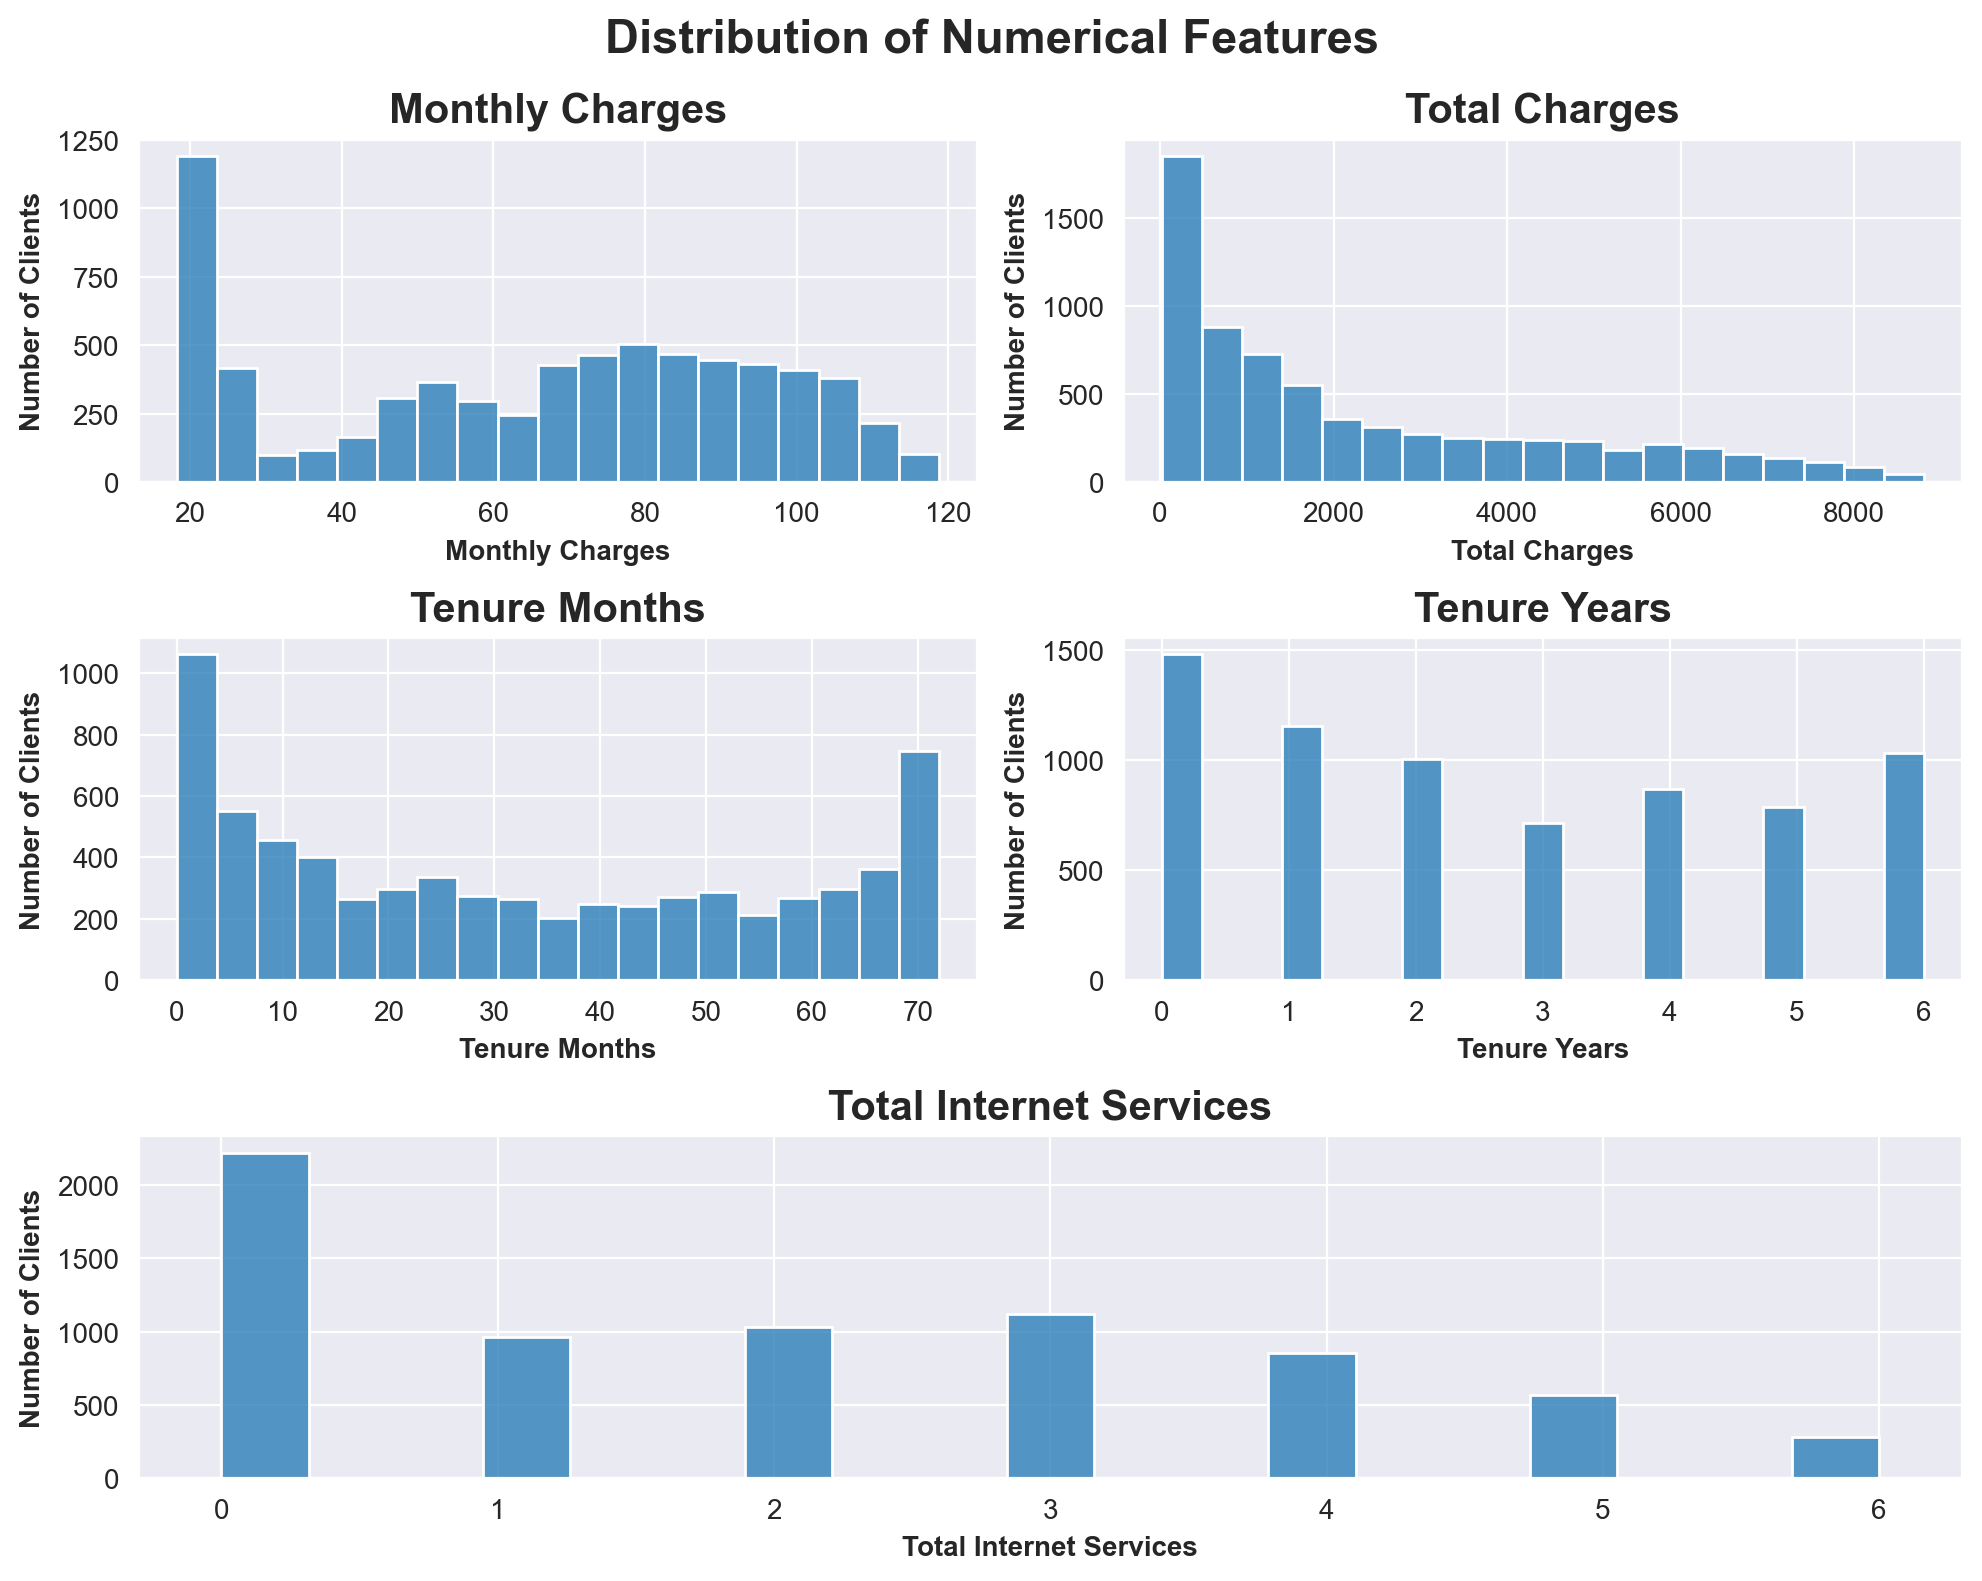

In [59]:
graph_numerical_features(data)

**_Notes:_**
- There appears to be a concentration of clients in the lower charge range, with a smoother distribution as the charges increase. This suggests that a significant portion of the client base is opting for less expensive plans - which is confirmed in our `Total Internet Services` distribution.
- The number of clients with no internet more than doubles that of clients with just a single internet package, let alone multiple. Perhaps we can work on a marketing campaign that bundles services together to also increase longevity in clients.
- The `Total Charges` distribution is heavily skewed right - implying that a majority of our clients our new - and also suggesting a possible class imbalance.
- However, reviewing the `Tenure` distributions, there is a minor class imbalance, but may not be large enough to address through balancing methods (_although potentially utilizing weight methods could prove useful_), but the `Tenure Months` distribution peaks at both ends, giving a "U" shape distribution. This implies clients either churn early, or stay for extended periods.

Let's observe the numerical feature distributions per the target class. 

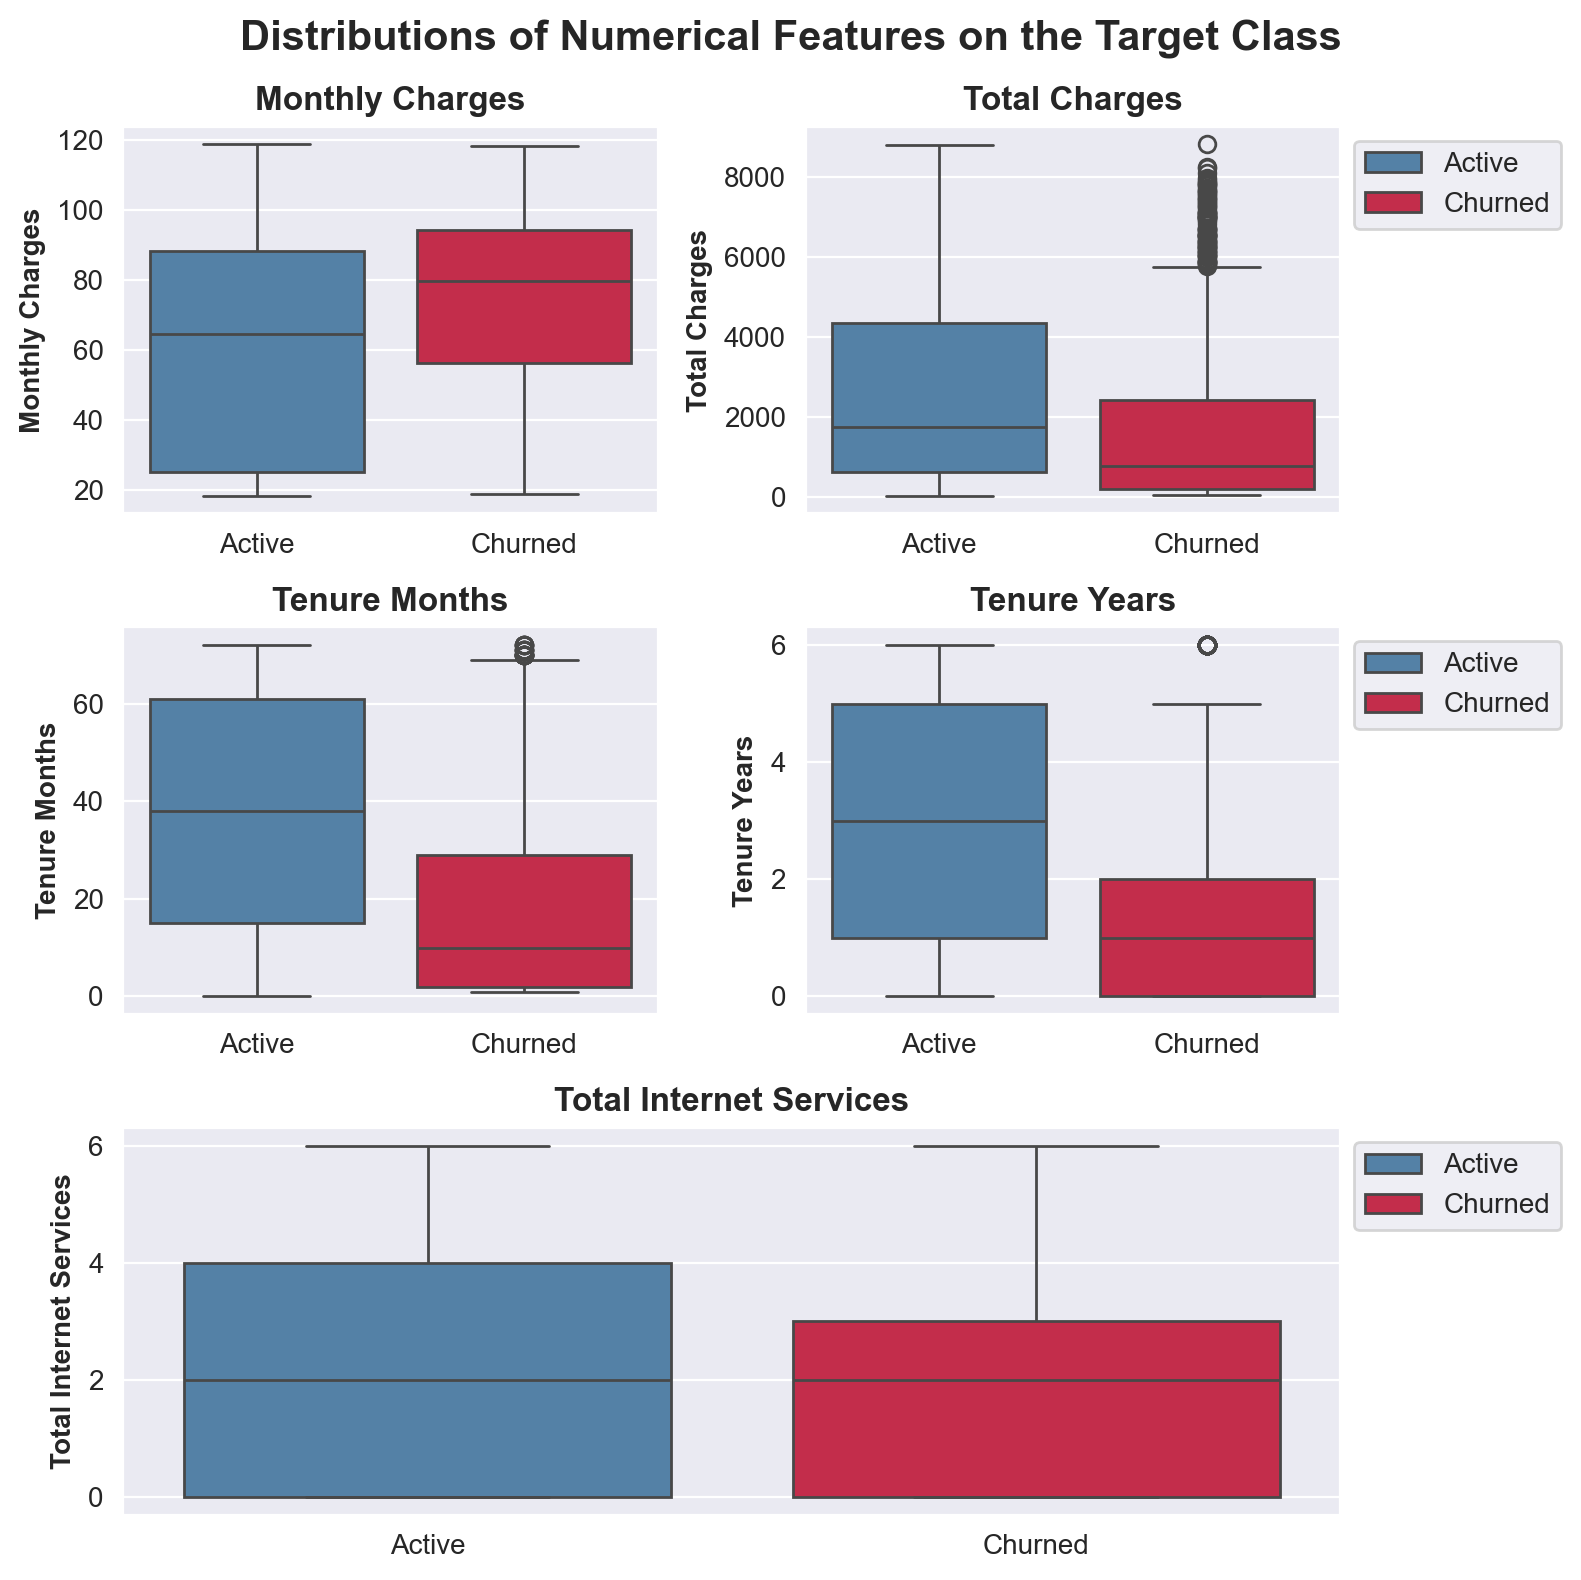

In [60]:
box_nums_on_target(data, 'churned')

**_Notes:_**

This distribution chart shares a massive amount of information!

- According to the `Monthly Charges` distribution, there is a significant increase in monthly charges (_including avg. monthly charges_) for those who have left versus those that have not. In fact, it's borderline outlier for those that have left to have a low monthly payment, making this a promising feature for ML models.
- This is oppositely observed in `Total Charges`, implying that those that leave, leave early; this reinforces our conclusions from the histograms. There are many outliers that have high total charges that have left - indicating this is not the best predictor due to the high variance, but is still relevant.
    - The outliers inform us that we should indeed perform some scaling as we predicted.
    - It's also possible that the outliers indicate an additional group present in the churned clients. If time allows, we may be able to investigate this. 
- The `Tenure` distributions show that tenure will likely be our strongest predictor of client churn. We can clearly see the median discrepency of Active customers having a median of 3 years, and 75% of all clients that have churned, did so within 2 years.
- The `Total Internet Services` distribution indicates that it will be a weaker predictor as both distributions have the same median. There is still relevant information for ML models to learn due to the deviations in their 75% quartile ranges.

[Back to Contents](#contents)

## 5.2 Categorical Features
<a id='cat_feats'></a>

We already have a list with our categorical features. Let's go ahead and make the graphs. 

There are 18 categorical features so the subplot will be packed with information, we will ensure to carefully analyze each chart in an organized and clear manor.

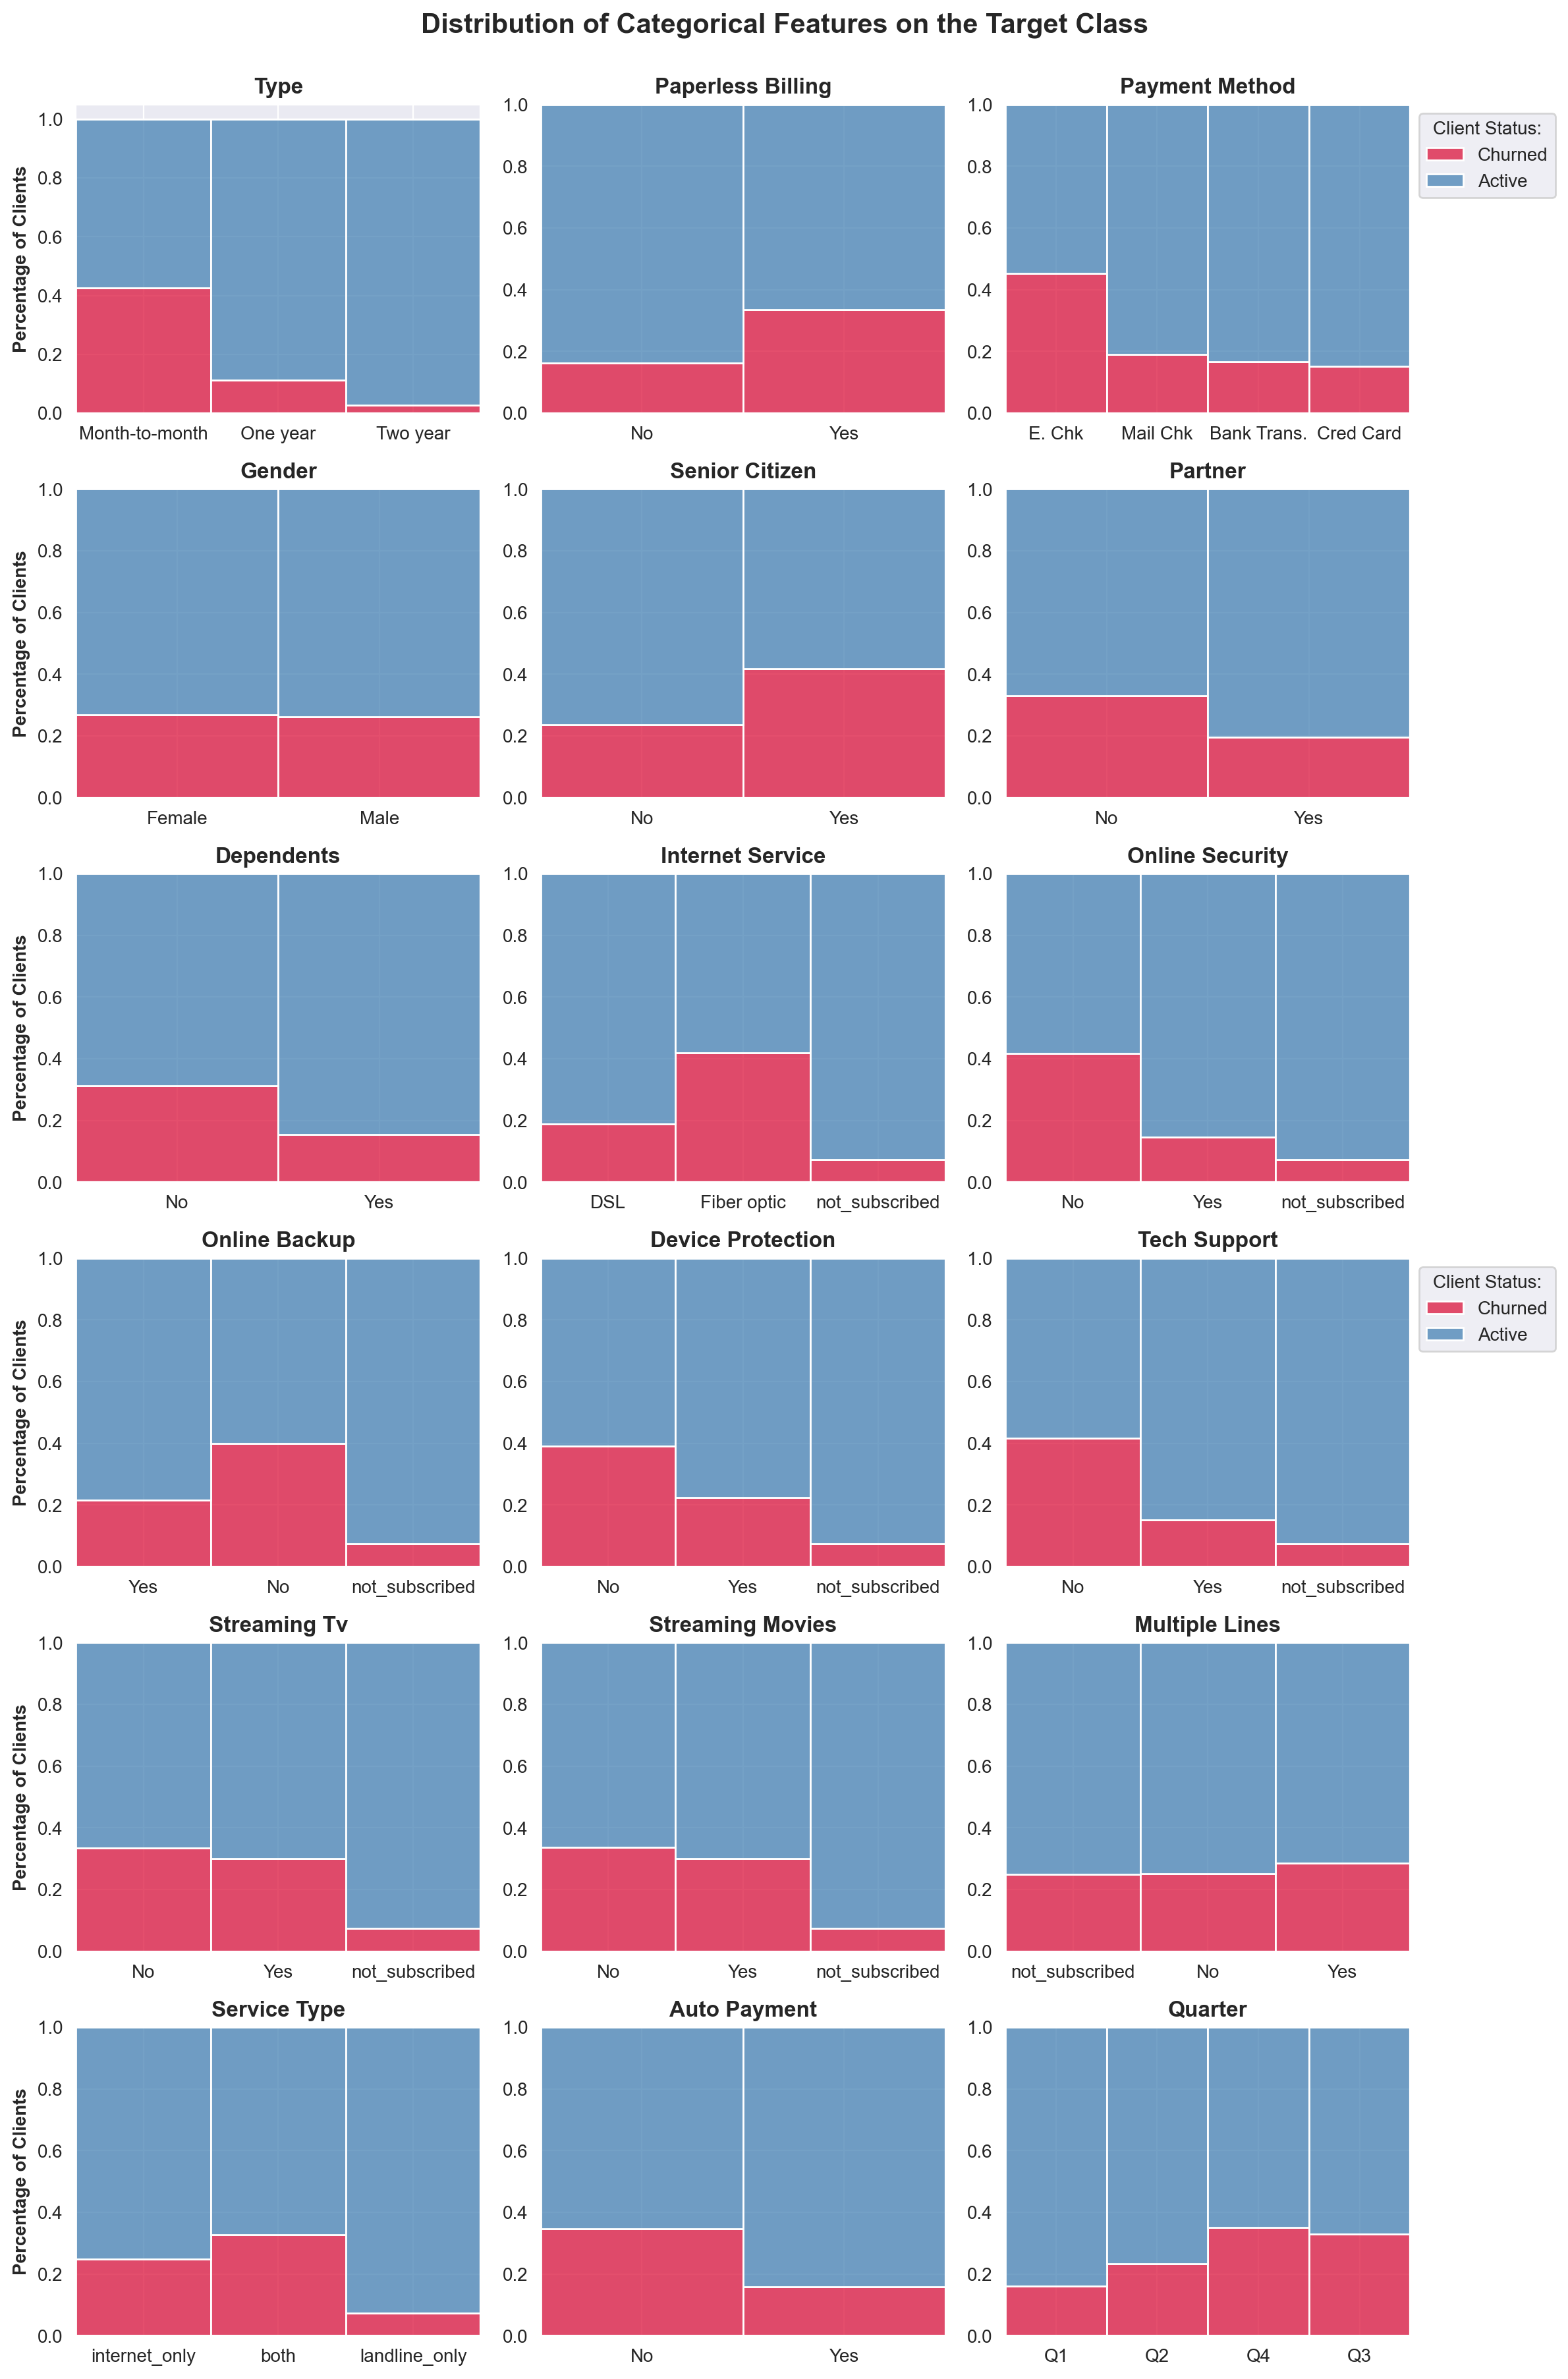

In [61]:
# Intitialize Figure - not barplot
categorical_features = {}

for feat in cat_feats:
    categorical_features[feat] = inflection.titleize(feat)
    
sns.set_style('darkgrid')

fig, axs = plt.subplots(ncols = 3, nrows = 6, figsize = (12, 18))
fig.suptitle("Distribution of Categorical Features on the Target Class",
             fontsize = 15, fontweight = 'bold', y=1.0)

axs = axs.flatten()

# plot the charts
for i, (feature, label) in enumerate(categorical_features.items()):
    sns.histplot(data = data, x = feature,
                hue = 'churned', palette = ['steelblue', 'crimson'],
                multiple = 'fill', discrete = True, ax = axs[i])
    axs[i].set_title(label, fontsize = 12, fontweight = 'bold')
    axs[i].set_xlabel("")

    # set up sepecific labeling
    if i == 2 or i == 11:
        axs[i].legend(title = 'Client Status:', loc = 'upper left', 
                      labels = ['Churned', 'Active'], bbox_to_anchor = (1,1))
    else:
        axs[i].get_legend().remove()

    if i in [0, 3, 6, 9, 12, 15]:
        axs[i].set_ylabel("Percentage of Clients", fontweight = 'bold')
    else:
        axs[i].set_ylabel("")

    if i in [1, 4, 5, 6, 16]:
        axs[i].set_xticks([0,1], ['No','Yes'])

    if i == 2:
        axs[i].set_xticks([x for x in range(0,4)], ['E. Chk', 'Mail Chk', 'Bank Trans.', 'Cred Card'])

plt.tight_layout()
plt.show()

# vetting
#print(axs[2].get_xticklabels())

**_Immediate Notes for Marketing Team:_**

Marketing should focus on our clients that are:
- subscribed on a **Monthly** basis;
- paying via **Electronic Check**;
- not set up for **automatic payments**;
- subscirbed to our **internet** with no additional packages;
- subscribed to our internet and have the **streaming tv and movies** packages as these packages have the highest churn rate.
- The marketing team should work hardest during **Quarters 3 & 4: Jul-Dec**.

As for our ML models:
- All fields will be great predictors of churn except for **Gender**, **Multiple Lines**, and possibly **Partner and Dependents** due to their uniform distributions. We will perform some additional testing to confirm `Partner` and `Dependents`, such as a Chi-squared test. 

### 5.2.1 Chi-Squared Tests
<a id='chi_test'></a>

The **Chi-squared** test will help determine if the categorical feature has a significant relationship with the target variable (*churned*). This can help determine if a feature is simply adding noise to the dataset, a feature that will not help make a prediction is a feature I don't want ML models being trained on. If the p-value is low (significantly less than 0.05) than we can conclude that the categorical feature is strongly related to *churn*, otherwise, we have great evidence of a noisy feature that can be removed. 

We will test the following features:
- Gender
- Partner
- Dependents
- Multiple Lines

In [62]:
# observe tables for test
tables_to_create = ['gender', 'partner', 'dependents', 'multiple_lines']

for col in tables_to_create:
    contingency_table(col)

Gender Contingency Table:


churned,0,1
gender,,
Female,2549,939
Male,2625,930


------------------------- 

Partner Contingency Table:


churned,0,1
partner,,
0,2441,1200
1,2733,669


------------------------- 

Dependents Contingency Table:


churned,0,1
dependents,,
0,3390,1543
1,1784,326


------------------------- 

Multiple_Lines Contingency Table:


churned,0,1
multiple_lines,,
No,2541,849
Yes,2121,850
not_subscribed,512,170


------------------------- 



In [63]:
# perform tests
for col in tables_to_create:
    chi_test(col)

Gender-Churned Chi-squared Test:
Chi-squared: 0.4840828822091383
P-value: 0.48657873605618596
Degrees of Freedom: 1
------------------------- 

We fail to reject the null hypothesis.
There is not enough evidence of association between the two variables.
The two variables are likely independent of each other.

Partner-Churned Chi-squared Test:
Chi-squared: 158.7333820309922
P-value: 2.1399113440759935e-36
Degrees of Freedom: 1
------------------------- 

We reject the null hypothesis.
There is enough evidence of association between the two variables.

Dependents-Churned Chi-squared Test:
Chi-squared: 189.12924940423474
P-value: 4.9249216612154196e-43
Degrees of Freedom: 1
------------------------- 

We reject the null hypothesis.
There is enough evidence of association between the two variables.

Multiple_Lines-Churned Chi-squared Test:
Chi-squared: 11.330441483197559
P-value: 0.0034643829548773046
Degrees of Freedom: 2
------------------------- 

We reject the null hypothesis.
There is

It appears that `gender` is the only feature independent of churn of our suspected features, although `multiple_lines`' p-value was much higher than the others, however we will leave that variable in, but we will **certainly drop `gender`** due to the noise it adds to the dataset and by not being a strong predictor due to its independence from the target. 

Before dropping the feature, let's confirm no dependies on other related features. 

In [64]:
# chi test partner and senior
print(chi_test('gender', 'senior_citizen'))
print(chi_test('gender', 'partner'))
print(chi_test('gender', 'dependents'))
print(chi_test('gender', 'monthly_charges'))
print(chi_test('gender', 'tenure_months'))

Gender-Senior_Citizen Chi-squared Test:
Chi-squared: 0.015604244282376655
P-value: 0.9005892996849594
Degrees of Freedom: 1
------------------------- 

We fail to reject the null hypothesis.
There is not enough evidence of association between the two variables.
The two variables are likely independent of each other.

0.015604244282376655
Gender-Partner Chi-squared Test:
Chi-squared: 0.016356470128040018
P-value: 0.8982341127357725
Degrees of Freedom: 1
------------------------- 

We fail to reject the null hypothesis.
There is not enough evidence of association between the two variables.
The two variables are likely independent of each other.

0.016356470128040018
Gender-Dependents Chi-squared Test:
Chi-squared: 0.7337079948513788
P-value: 0.39168391711610406
Degrees of Freedom: 1
------------------------- 

We fail to reject the null hypothesis.
There is not enough evidence of association between the two variables.
The two variables are likely independent of each other.

0.73370799485

It does not appear that `gender` relates to other features. **We can safely drop this feature from our dataset before ML training.** 

We will however, confirm this decision when observing the correlations later in the EDA. 

[Back to Contents](#contents)

## 5.3 Distribution of the Target Class
<a id='targ_dist'></a>

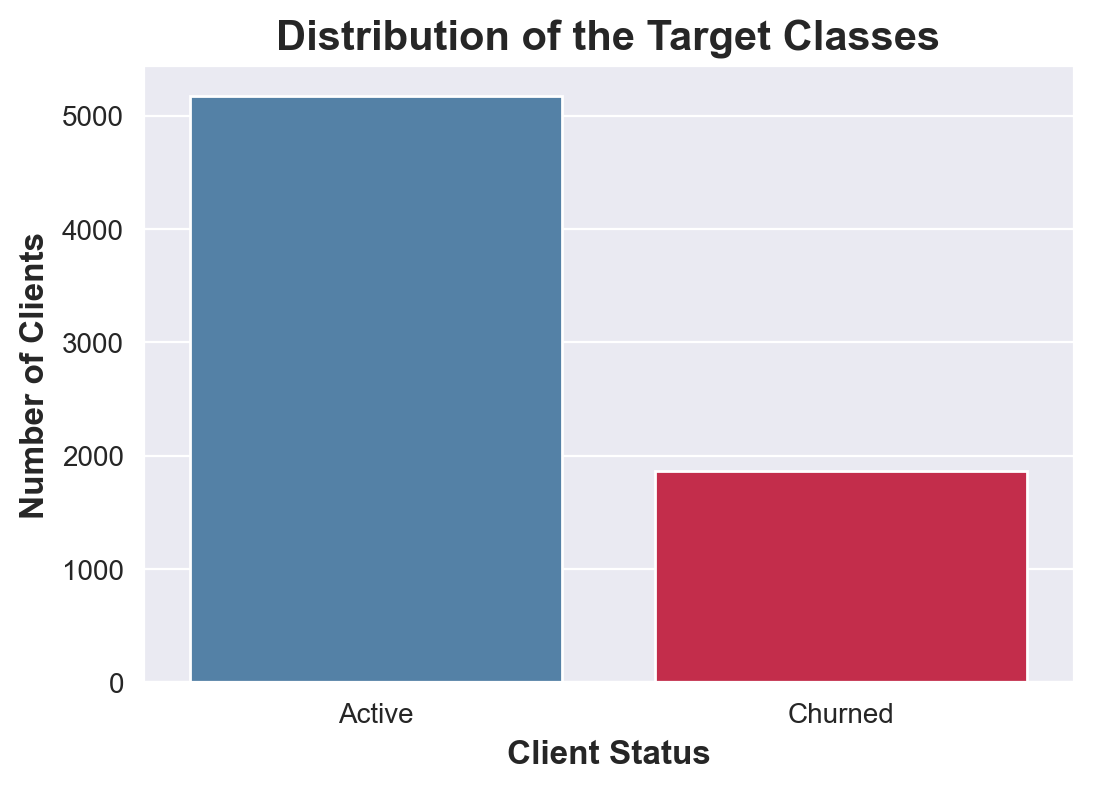

In [65]:
# initialize figure
sns.set_style('darkgrid')

plt.figure(figsize = (6,4))

sns.countplot(data = data, x = 'churned',
              hue = 'churned',
              palette = ['steelblue', 'crimson'],
              legend = False)

plt.title("Distribution of the Target Classes", 
          fontsize = 15, fontweight = 'bold')
plt.xlabel("Client Status", fontsize = 12, fontweight = 'bold')
plt.ylabel("Number of Clients", fontsize = 12, fontweight = 'bold')
plt.xticks([0, 1], ['Active', 'Churned'])

plt.show()

There is a massive imbalance in the target classes. This will need to be addressed via some sort of balancing method. 

Initially I am considering adjusting class weights as our parameter tuning will be quite robust and this method should work well. If not, then some combination of upsampling and downsampling via SMOTE may also work well. 

According to our [Work Plan](#the_plan), the only models wea are planning on traning that don't directly support class weight adjustment is `AdaBoost` and `HistGradientBoost`, but we can use sample weighting during training to achieve similar affects, so no major plan adjustments need to be made. 

[Back to Contents](#contents)

## 5.4 Monthly Payments
<a id='month_pay'></a>

We have already observed the overall distribution for this feature as well as the boxplot distributions on the target class. We determined that there is in fact a difference in that clients that have churned have significantly higher monthly charges. 

Let's investigate a little further and see if we can determine groups of clients based on monthly charges that marketing could target. 

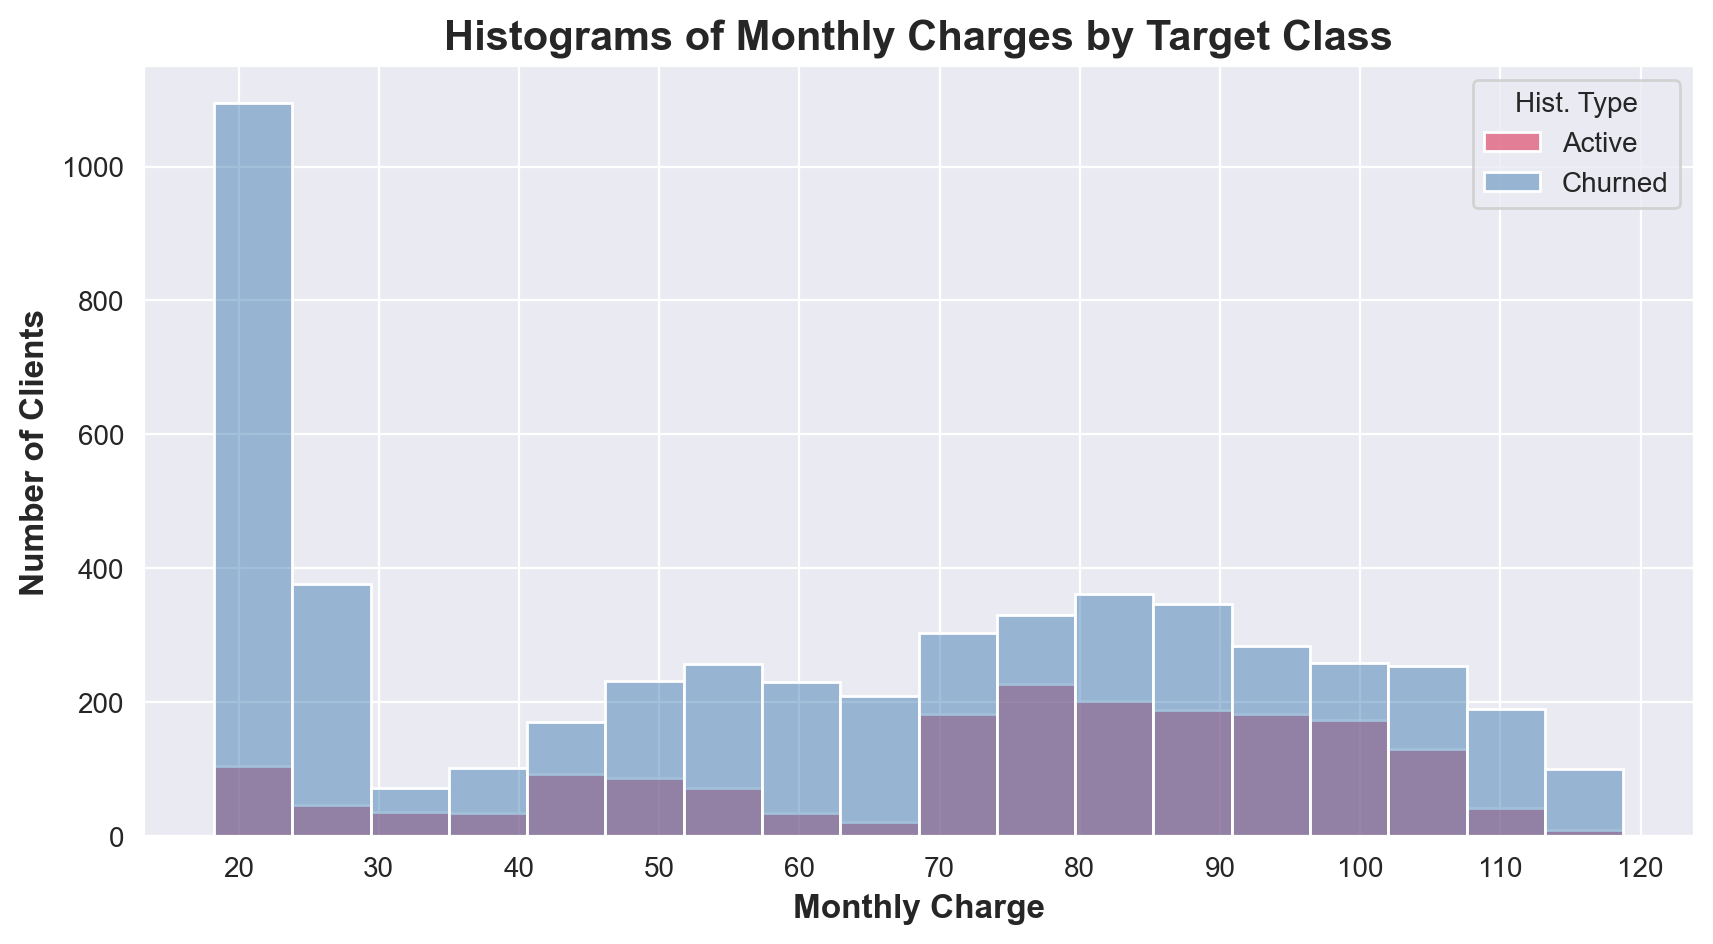

In [66]:
# combined histogram
sns.set_style('darkgrid')

plt.figure(figsize = (10, 5))

sns.histplot(data = data, x = 'monthly_charges', hue = 'churned',
             palette = ['steelblue', 'crimson'])

plt.title("Histograms of Monthly Charges by Target Class", 
          fontsize = 15, fontweight = 'bold')
plt.xlabel("Monthly Charge", fontsize = 12, fontweight = 'bold')
plt.ylabel("Number of Clients", fontsize = 12, fontweight = 'bold')
plt.xticks([x for x in range(20, 130, 10)])
plt.legend(title = "Hist. Type", labels = ['Active', 'Churned'])

plt.show()

It appears there are waves from 0-40, 40-70, 70-110, and 110+. Let's look at the percentage of Active vs. Churned clients in these ranges. 

In [67]:
# Define bins
bins = [0, 40, 70, 110, data['monthly_charges'].max()]
labels = ['0-40', '40-70', '70-110', '110+']

# use cut
mc_group = pd.cut(data['monthly_charges'], bins=bins, labels=labels).to_frame()

mc_group['churned'] = data['churned']

# get percentages
charge_cross = round(pd.crosstab(mc_group['monthly_charges'], mc_group['churned'], normalize = 'index') * 100, 2)
charge_cross.columns = ['Active', 'Churned']
charge_cross = charge_cross[['Churned', 'Active']]

charge_cross

,Churned,Active
monthly_charges,,
0-40,11.64,88.36
40-70,23.92,76.08
70-110,36.79,63.21
110+,13.02,86.98


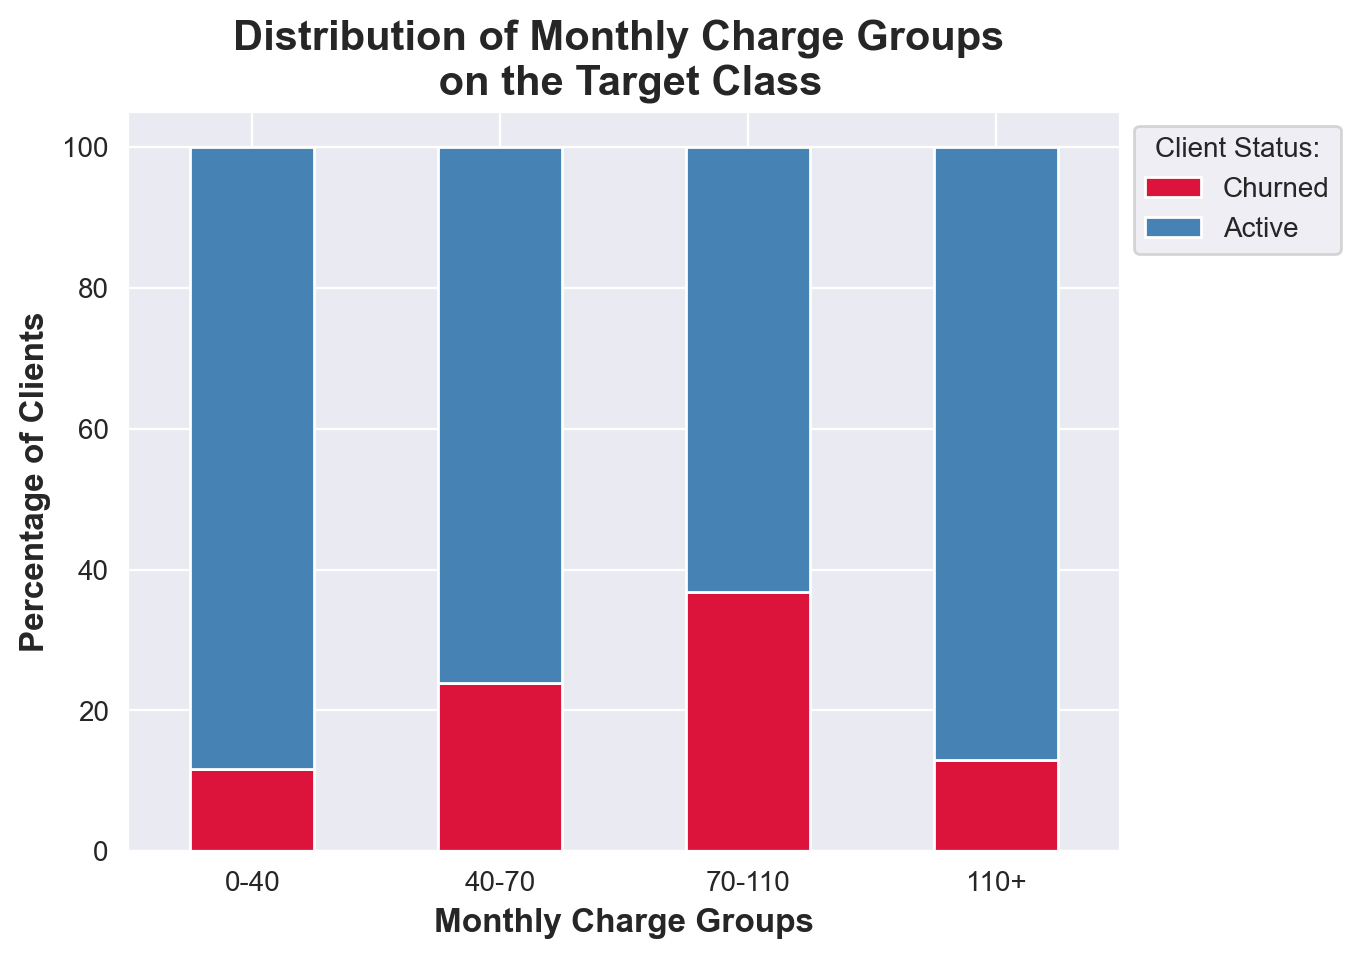

In [68]:
# graph the crosstab
charge_cross.plot(kind = 'bar', 
                  stacked = True,
                  color = ['crimson', 'steelblue'])

plt.title("Distribution of Monthly Charge Groups \n on the Target Class",
          fontsize = 15, fontweight = 'bold')
plt.xlabel("Monthly Charge Groups", fontsize = 12, fontweight = 'bold')
plt.ylabel("Percentage of Clients", fontsize = 12, fontweight = 'bold')
plt.xticks(rotation = 0)
plt.legend(title = "Client Status:", loc = 'upper left', 
           labels = ['Churned', 'Active'], bbox_to_anchor = (1,1))

plt.show()

It appears there is in fact groups of clients marketing can target. They should focus their campaigns on clients with monthly charges in the 40-110 range, but more specifically the 70-110 range. This data seems valueable to ML models, let's add it to the data set. 

Also, we get to intentionally add ordinal relationships as there are clear predictive relationships among the groups, this will significantly help reduce the amount of features if left simply as a categorical feature via OHE.

In [69]:
def calc_charge_group(row):
    '''
    Function to calculate which monthly charge group the client is in.
    '''

    if row['monthly_charges'] >= 0 and row['monthly_charges'] < 40:
        return 1
    elif row['monthly_charges'] >= 40 and row['monthly_charges'] < 70:
        return 3
    elif row['monthly_charges'] >= 70 and row['monthly_charges'] < 110:
        return 4
    else:
        return 2

In [70]:
data['charge_group'] = data.apply(calc_charge_group, axis = 1)

# observe
data[['monthly_charges', 'charge_group']].sample(5, random_state = 15)

,monthly_charges,charge_group
5545,86.55,4
1657,25.60,1
2218,82.00,4
4392,19.20,1
1461,95.90,4


Excellent, let's proceed to the percentages of each service type. 

[Back to Contents](#contents)

## 5.5 Percentages of Clients by Service Type
<a id='serv_type'></a>

We want to observe the percentage of clients within the following columns: `service_type`, `multiple_lines`, `internet_service`, and `tot_internet_services`

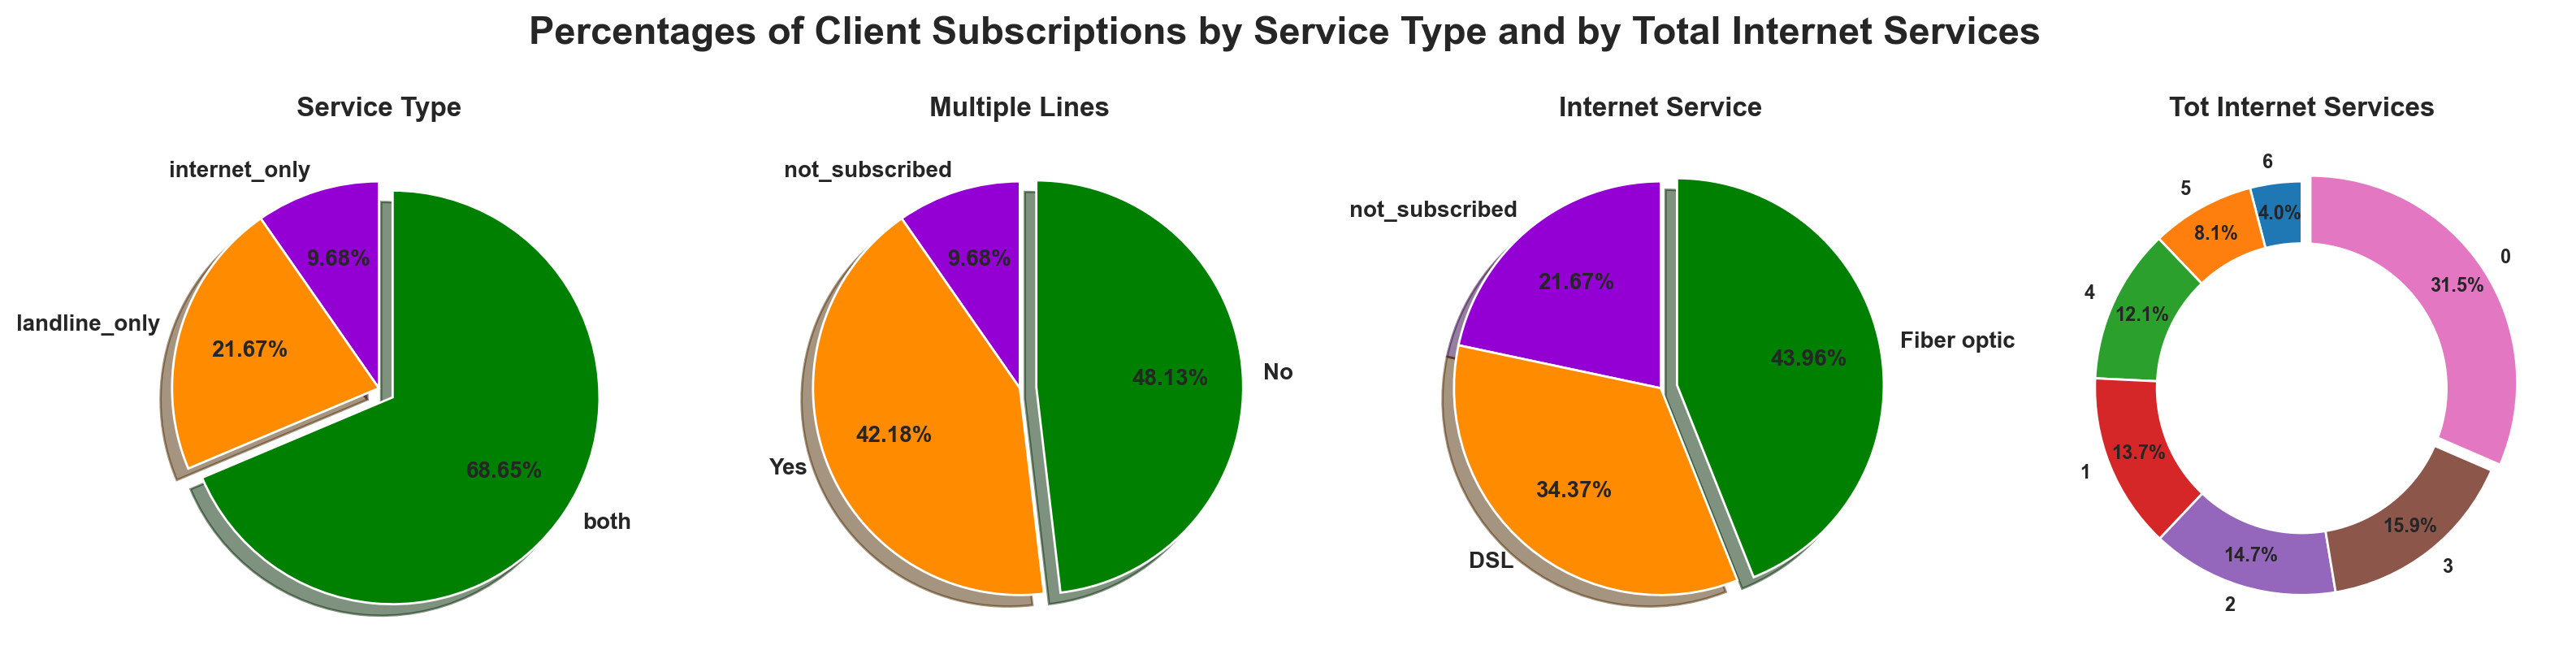

In [71]:
pies_to_make = ['service_type', 'multiple_lines', 'internet_service', 'tot_internet_services']

fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (16, 6))
fig.suptitle("Percentages of Client Subscriptions by Service Type and by Total Internet Services",
             fontsize = 17, fontweight = 'bold', y=0.85)

for i, col in enumerate(pies_to_make):
    percs = round(data[col].value_counts(normalize = True) * 100, 2).sort_values()
    ax = axs[i]

    if i < 3:
        ax.pie(
            x = percs,
            labels = percs.index,
            autopct = '%1.2f%%',
            colors = ['darkviolet', 'darkorange', 'green'],
            startangle = 90,
            shadow = True,
            explode = (0,0,0.08),
            pctdistance = 0.65,
            textprops = {'fontweight':'bold'})

        plt.title(' '.join(col.title().split('_')))
    else:
        ax.pie(
            x = percs,
            labels = percs.index,
            autopct = '%1.1f%%',
            startangle = 90,
            shadow = False,
            explode = (0, 0, 0, 0, 0, 0, 0.05),
            pctdistance = 0.85,
            textprops = {'fontsize': 8.5, 'fontweight':'bold'}
            #wedgeprops = {'edgecolor': 'black'}
        )
        plt.gca().add_artist(plt.Circle((0, 0), 0.7, color='white')) # donut chart

    ax.set_title(' '.join(col.title().split('_')), fontsize = 12, fontweight = 'bold')
        
plt.tight_layout()
plt.show()

**_Notes:_**
- Most clients are subscribed to both internet and landline services. However, the clients subscribed to internet services are considerably higher risk so we learn that only 21.67% of the clients are relatively safe. Our phone satisfaction must be high!
- Considering the stability of the landline service clients, the marketing team should focus on the 9.68% of clients not subscribed, as this would improve retention.
- Of the clients subscribed to our internet packages, `Fiber Optic` is the most popular, likely because it is the better connection, however churn is high among our internet clients so maybe something is wrong with our connection speeds and timings.
- Of the offered internet services, not including those unsubscribed, having 3 additional packages is the most popular, followed closely by 2. It will be interesting to see this feature on the target class. *See distribution below!*

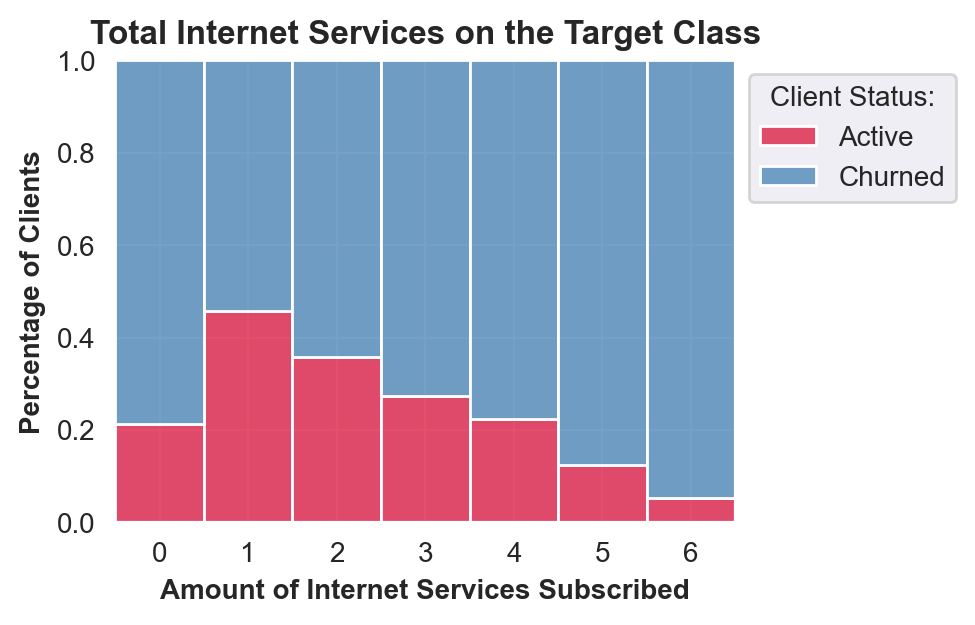

In [72]:
sns.set_style('darkgrid')

plt.figure(figsize = (4,3))
sns.histplot(data = data, x = 'tot_internet_services', hue = 'churned',
             palette = ['steelblue', 'crimson'], multiple = 'fill',
             discrete = True)

plt.title("Total Internet Services on the Target Class", 
          fontsize = 12, fontweight = 'bold')
plt.xlabel("Amount of Internet Services Subscribed", fontweight = 'bold')
plt.ylabel("Percentage of Clients", fontweight = 'bold')
plt.legend(title = "Client Status:", labels = ['Active', 'Churned'], bbox_to_anchor = (1,1))

plt.show()

- As we can see churn rate increases with internet services closer to 1, with 1 being the highest. Informing us that although internet subscribers pose the greatest risk, they are less likely to leave if subscribed to additional internet services, but it has to be more than 4 to be less likely than not subscribing at all.
- This data is even more interesting because we know from our pie charts that the most popular amount of services is 3, so this indicates we should reflect on our competitiveness when it comes to our packages, or other internal factors. The goal internally should be to decrease the percentage of customers that leave for having 3 packages through some kind of incentivization to not only increase profits, but increase retention as well. 

[Back to Contents](#contents)

## 5.6 Customer Inflow and Outflow
<a id='in+out'></a>

We've already done a quarter analysis and learned that clients tend to leave in months Jul-Dec, but more so in Oct-Dec. However, let's look at each dates individually and see if we see an even finer pattern. 

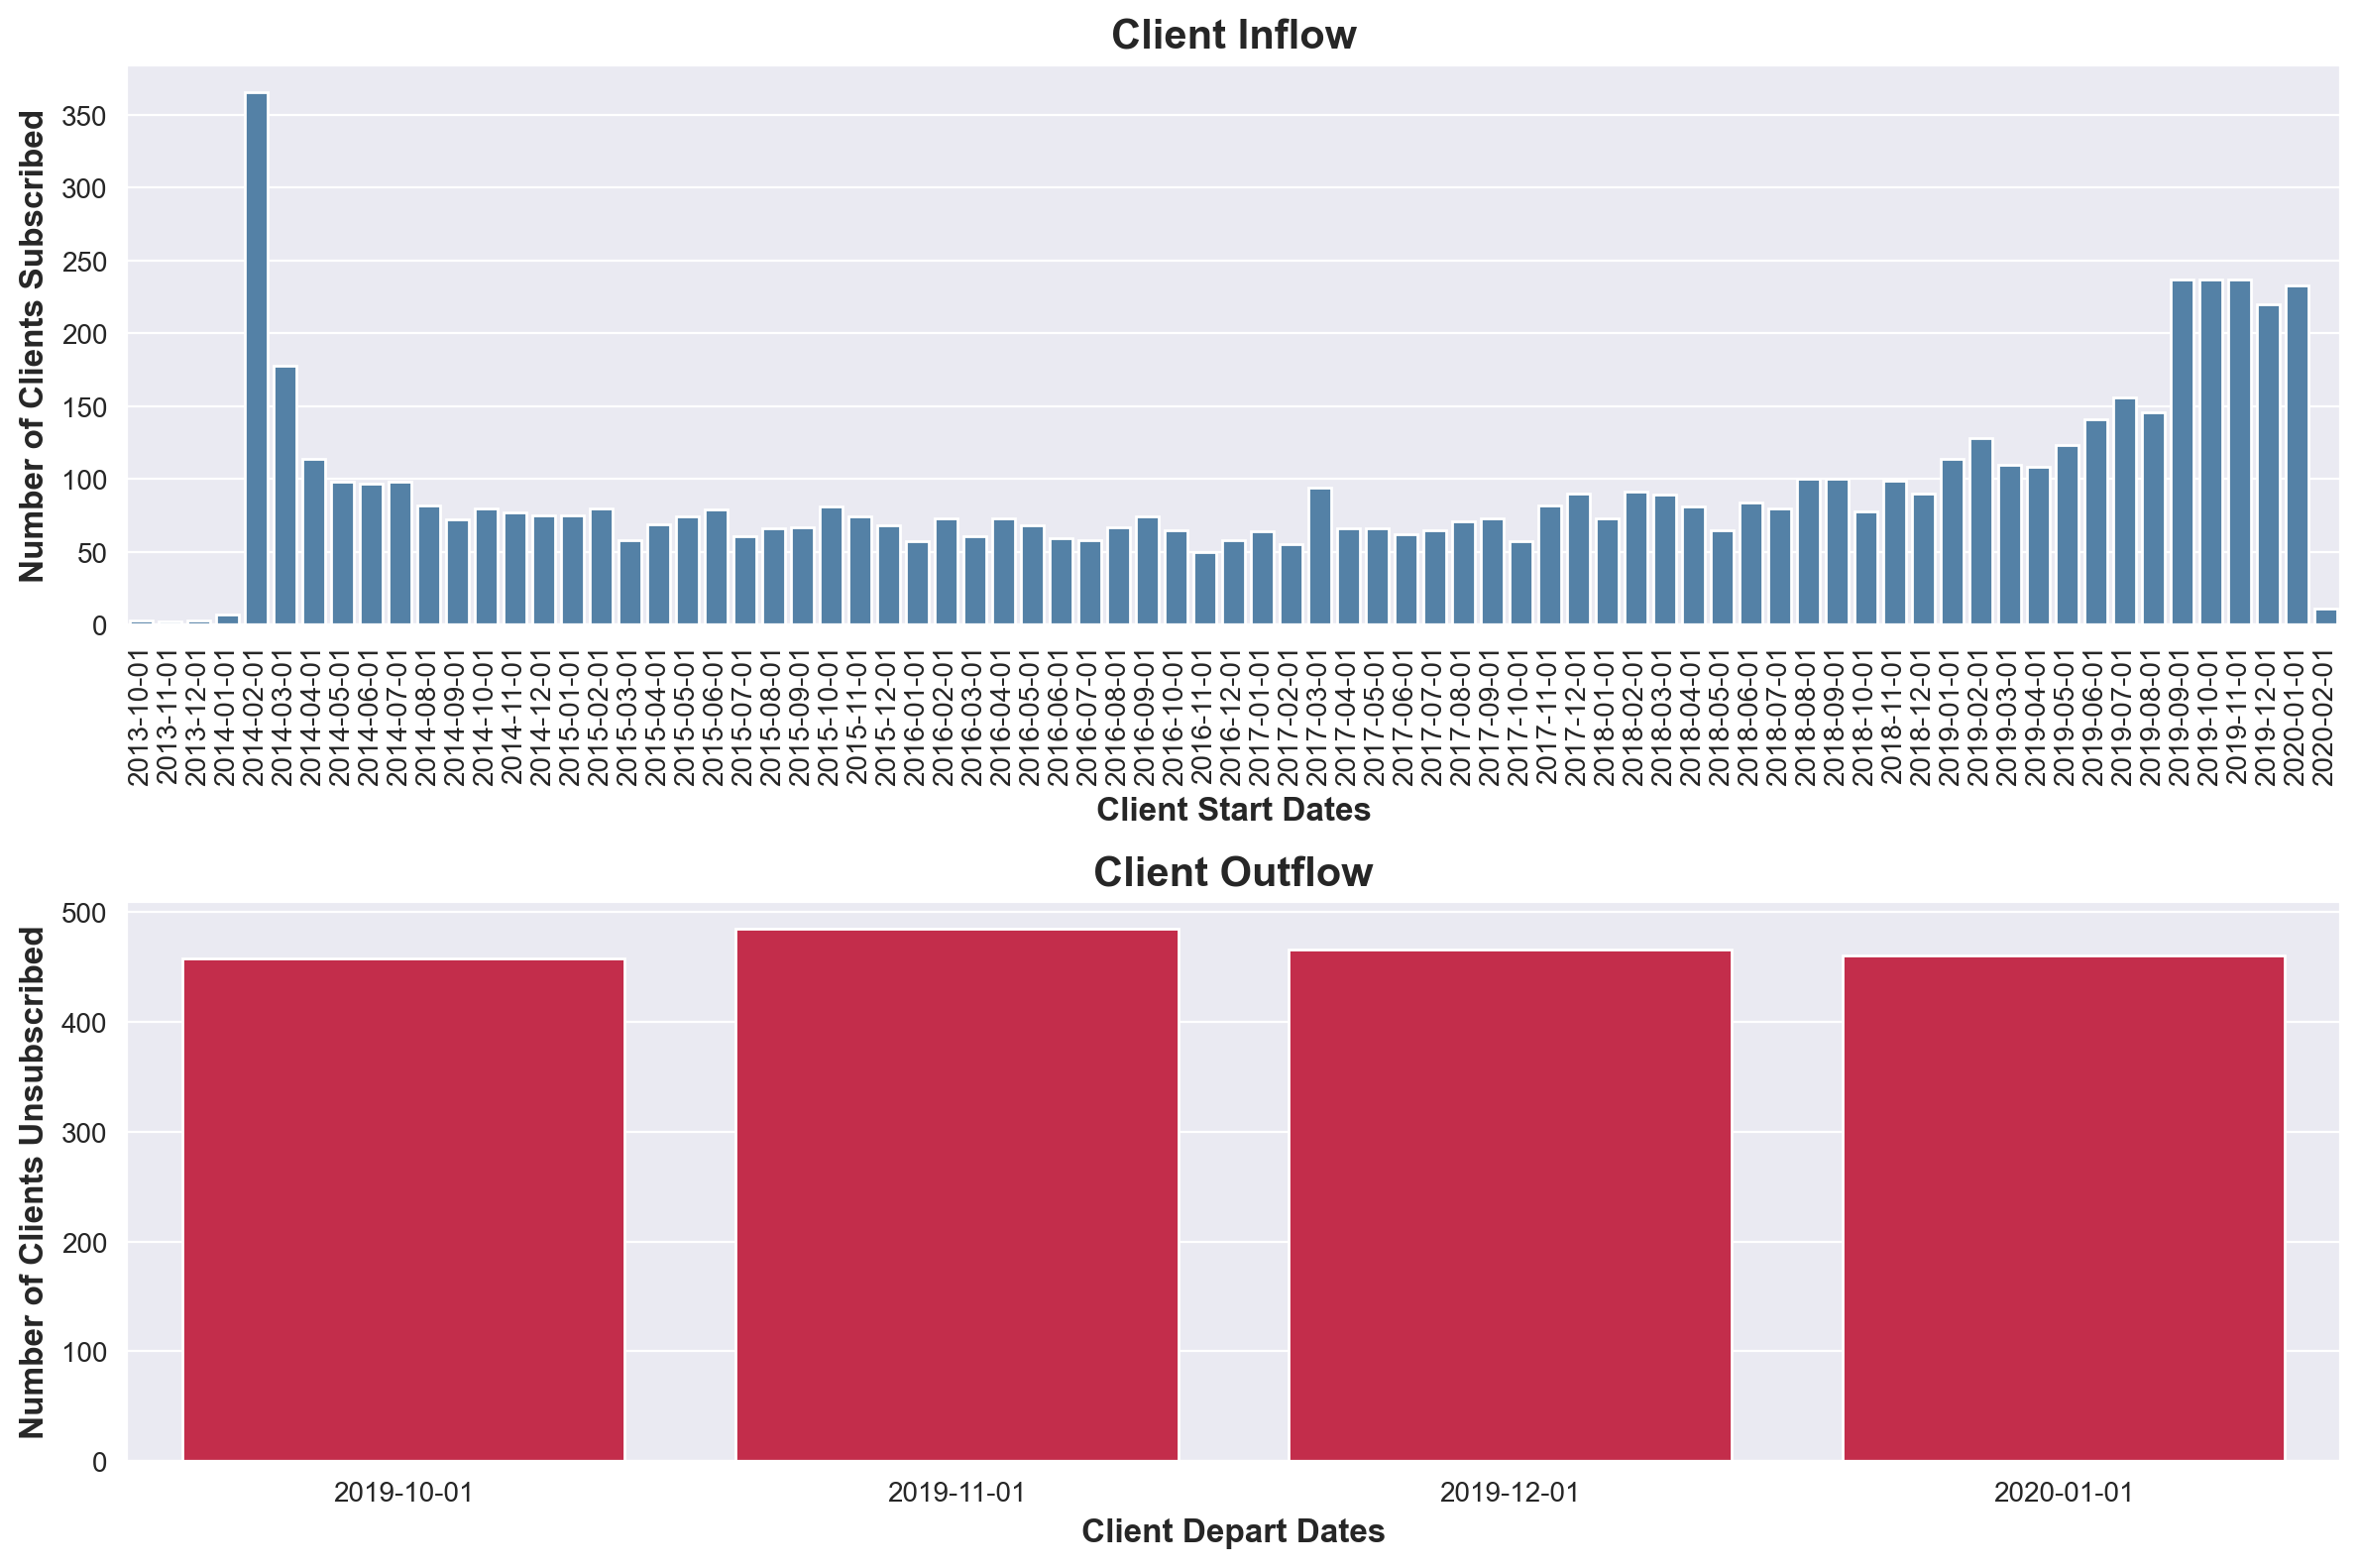

In [73]:
start_counts = data['begin_date'].value_counts().sort_index()

fig, axs = plt.subplots(ncols = 1, nrows = 2, 
                        figsize = (12, 8))

ax = axs[0]

# chart
sns.barplot(x = start_counts.index, y = start_counts.values, 
            color = 'steelblue', ax = ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation = 90)
ax.set_title("Client Inflow", fontsize = 15, fontweight = 'bold')
ax.set_xlabel("Client Start Dates", fontsize = 12, fontweight = 'bold')
ax.set_ylabel("Number of Clients Subscribed", fontsize = 12, fontweight = 'bold')

ax = axs[1]
end_counts = data['end_date'].value_counts().sort_index()

sns.barplot(x = end_counts.index, y = end_counts.values,
            color = 'crimson', ax = ax)
ax.set_title("Client Outflow", fontsize = 15, fontweight = 'bold')
ax.set_xlabel("Client Depart Dates", fontsize = 12, fontweight = 'bold')
ax.set_ylabel("Number of Clients Unsubscribed", fontsize = 12, fontweight = 'bold')

plt.tight_layout()
plt.show()

**_Notes:_**

- I'm glad I didn't make a quarter-left feature (that would cause data leakage anyway) because the only departure data we have is for the past 4 months. We can only hypothesize on why this is, but likely didn't start tracking it until October of 2019. Unable to discern any patterns from the departure data.
- There does not appear to be any patters in the start dates as well. Larger influx of clients in the later months of 2019, possibly why more departures? People may be changing their mind or the market is shaking up. Hard to say without external information. No real pattern to discern.
- One observation we can make is that the amount of clients leaving are doubling that of clients entering. We need better marketing/prices/incentives!

[Back to Contents](#contents)

## 5.7 Correlation Matrix
<a id='corr'></a>

### Numerical Features

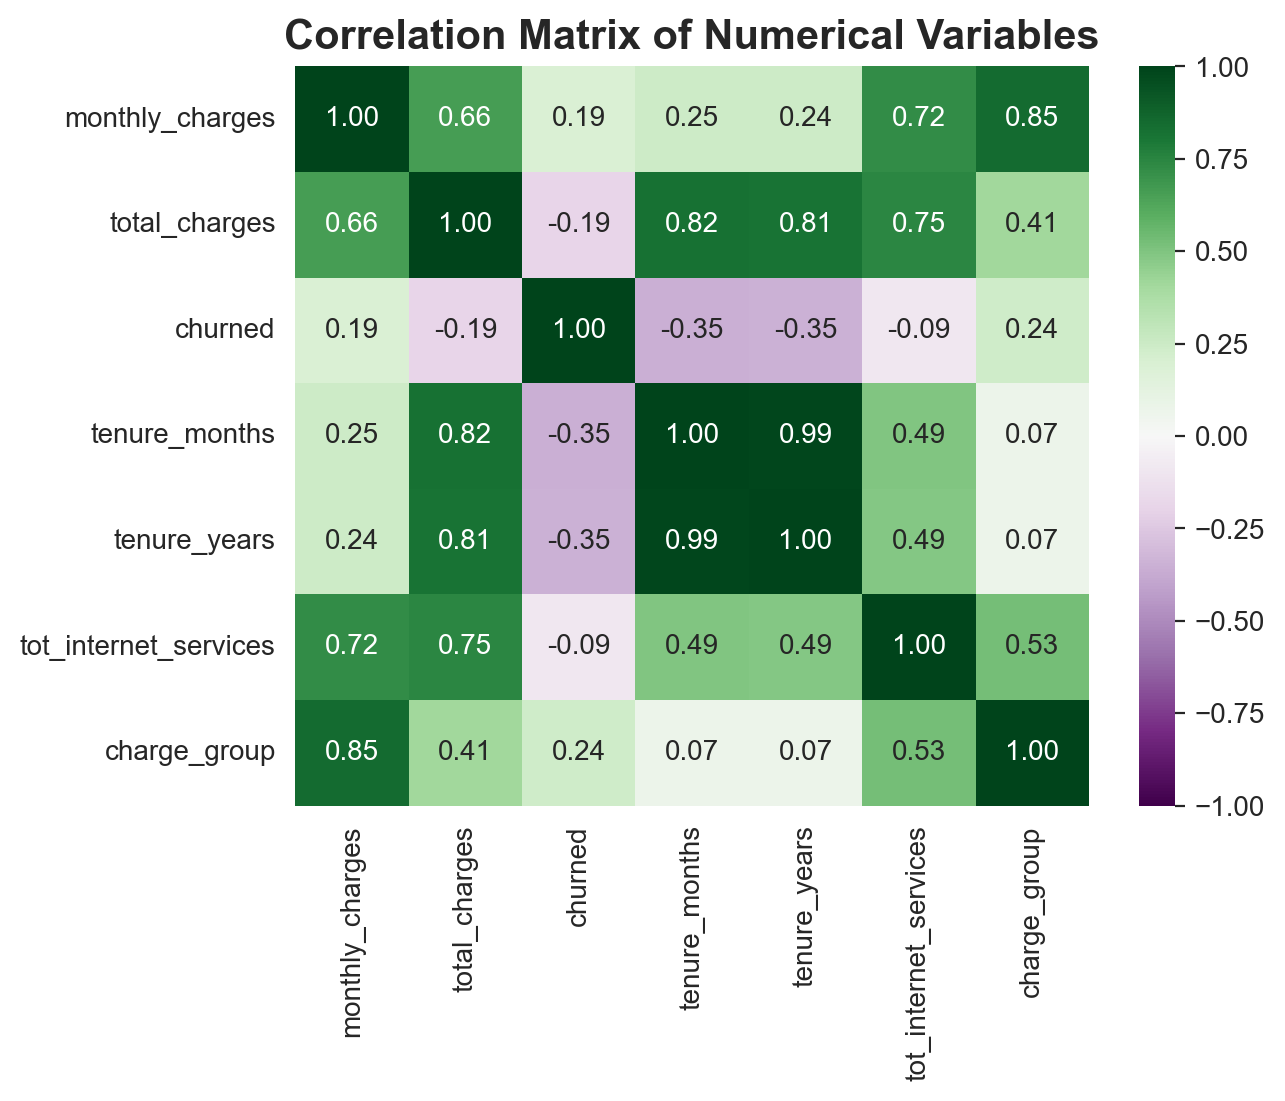

In [74]:
sns.heatmap(
    data = data.drop(columns = cat_feats + ['customer_id', 'begin_date', 'end_date']).corr(),
    vmin = -1, vmax = 1,
    cmap = 'PRGn', center = 0,
    annot = True, fmt = '.2f',
    linecolor = 'black'
)
plt.title("Correlation Matrix of Numerical Variables", fontsize = 15, fontweight = 'bold')
plt.show()

**_Notes:_**

- We can see that most correlations are positive, with the negative correlations actually only relating to the target. 
- As predicted, tenure is our strongest predictor, followed by our engineered `charge_group` and then `monthly_charges`. 
- The weakest correlation being with `tot_internet_services`, but we will not remove it as it correlates very well to other features.
    - We also cannot remove `monthly_charges` for the same reason. 

### Categorical Features

Unfortunately, we cannot observe a correlation matrix on categorical features, but we can observe whether there is a significant association via the chi-squared test. We can then further assess the strength of that association via **Cram&eacute;r's V**, and build our own matrix with those values for all the categorical features and the target. 

Cram&eacute;r's V normalizes its result on a scale of 0-1, which will make our matrix easy to interpret: the closer to 1, the stronger the association between the categorical features.

In python, our target feature is a numeric, but for our statistical testing, we can safely treat a binary numeric feature (_e.g.,_ 0/1) as categorical for this analysis.

To obtain the Cram&eacute;r's V measurement, we will use the following formula:

---
$$ V = \sqrt{\frac{\chi^2}{n (k - 1)}} $$

---

Where:
- $V$ is the Cram&eacute;r's V measurement value
- $\chi^2$ is the chi-squared test statistic
- $n$ is the total sample size
- $k$ is the smaller of the number of rows or columns between the two variables

Generally, a V value of 0.1 is weak, 0.3 is moderate, and 0.5+ is strong, but it does depend on the degrees of freedom. In most of our crosses, that will be 1, but for our interpretations we could be more conservative with 0.2 being weak, and 0.6+ being strong for non-binary features.  

The important takeaway when interpreting the matrix is that for binary feature analysis, the **degrees of freedom** ($k$) will be 1. Therefore, will use the first set of thresholds for interpretation: (_$V$ = 0.1 **as weak** and $V$ $\geq$ 0.5 **as strong**_).

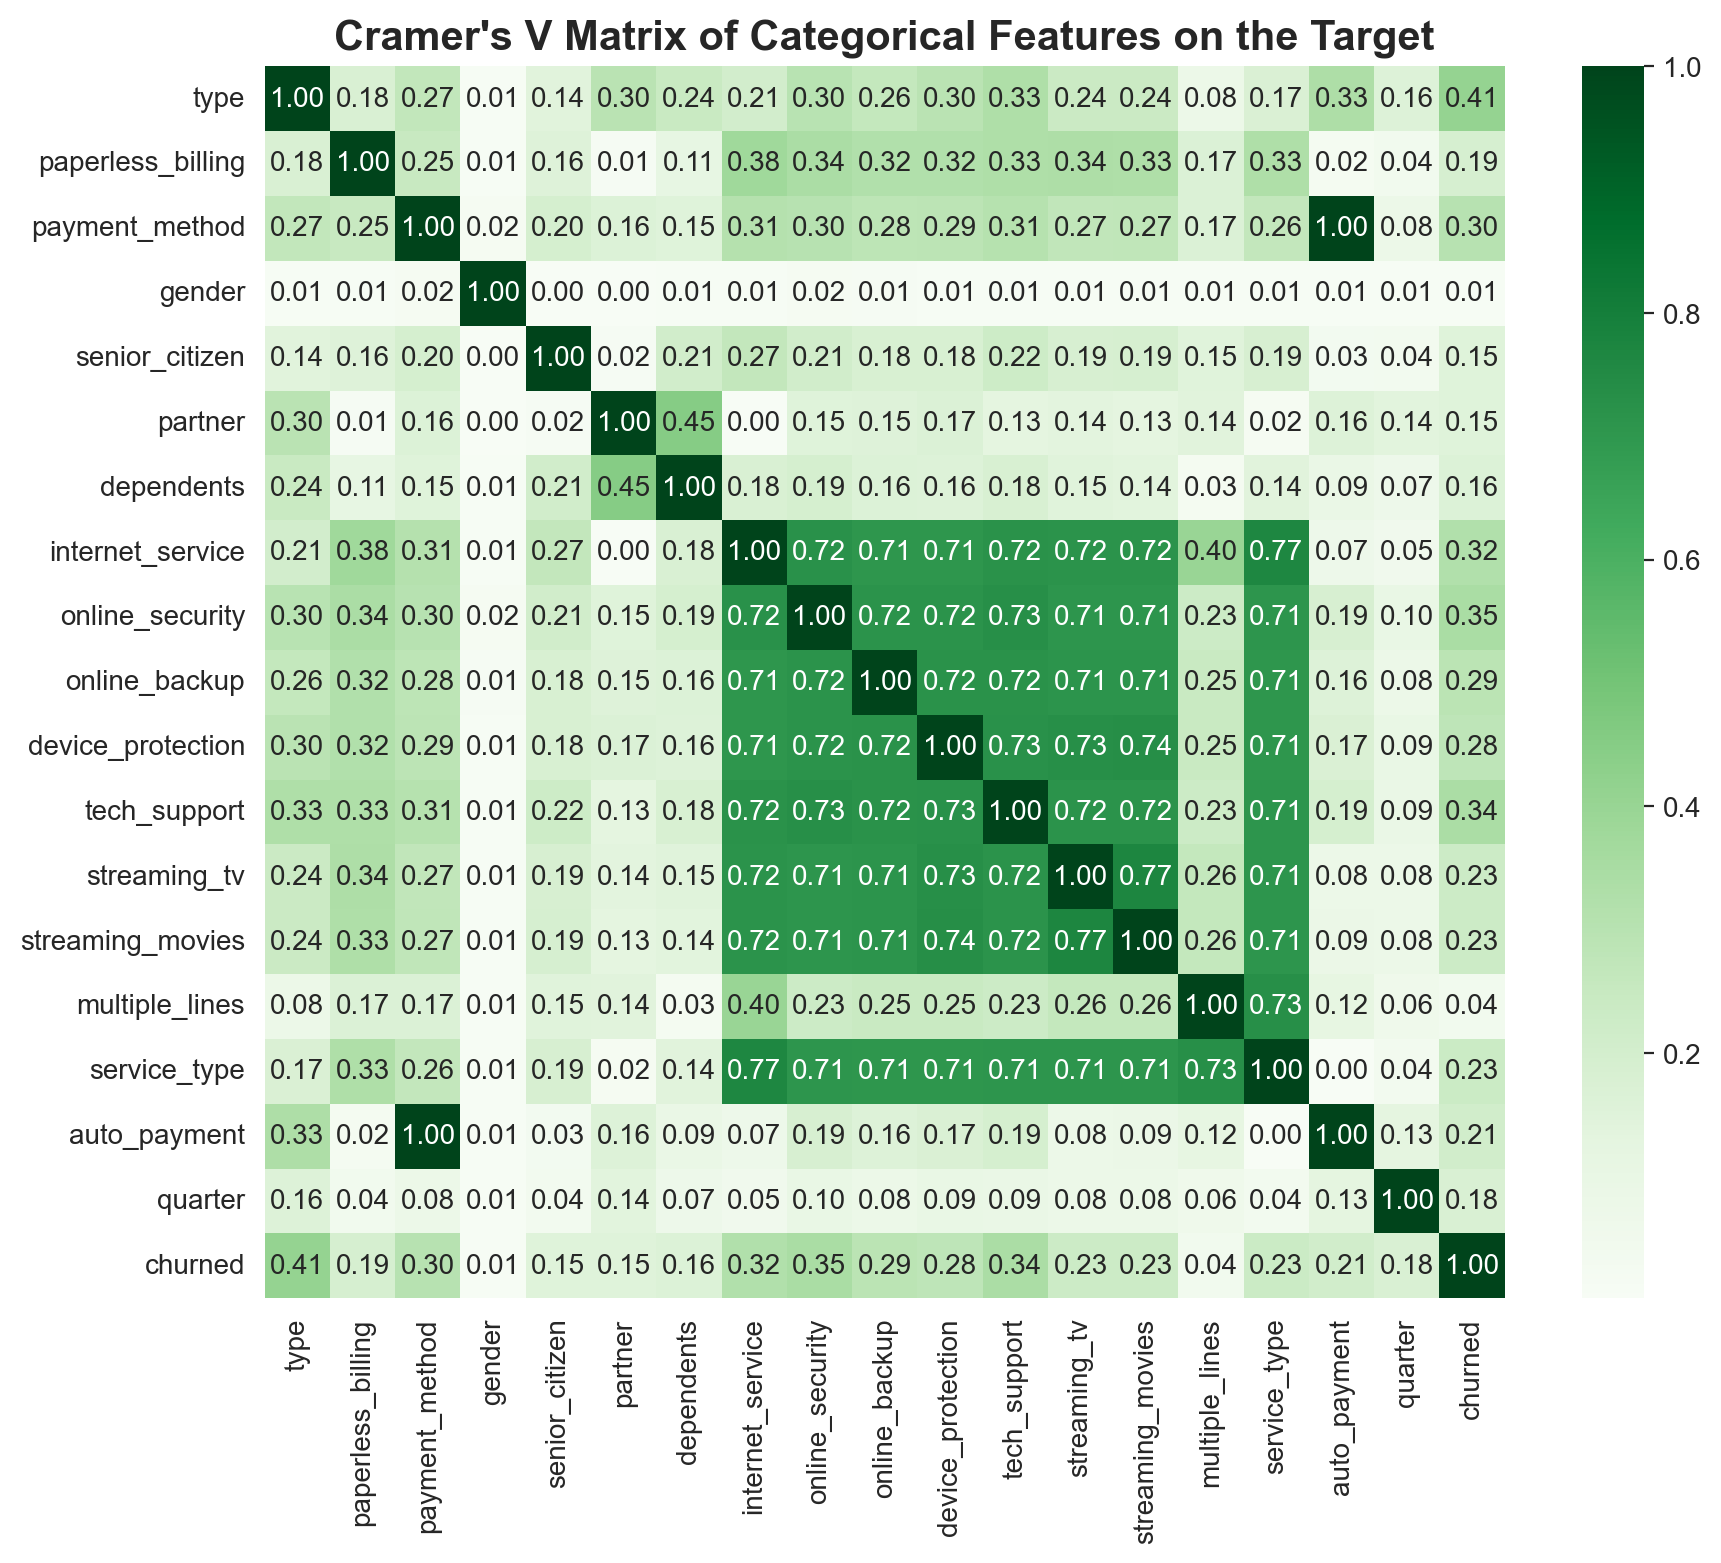

In [75]:
# Implement function to create matrix
# establish blank matrix to fill
cramer_feats = cat_feats + ['churned']
cramer_len = len(cramer_feats)

cramer_matrix = np.zeros((cramer_len, cramer_len))

# fill blank matrix
for i in range(cramer_len):
    for j in range(cramer_len):
        if i == j:
            cramer_matrix[i, j] = 1.0 # Diagonal
        else:
            cramer_matrix[i, j] = cramers_v(cramer_feats[i], cramer_feats[j])

cramer_df = pd.DataFrame(cramer_matrix, index = cramer_feats, columns = cramer_feats)

# observe / vet results
#display(cramer_df.head())
#print('\nMatrix for Churned:')
#cramer_df['churned']

# plot the heatmap
plt.figure(figsize = (10, 8))

sns.heatmap(
    data = cramer_df,
    cmap = 'Greens',
    annot = True, fmt = '.2f',
    linecolor = 'black'
)
plt.title("Cramer's V Matrix of Categorical Features on the Target",
          fontsize = 15, fontweight = 'bold')

plt.show()

**_Notes:_**

This chart perfectly summarizes our previous findings:
- Almost all categorical features have a moderate association with the target. 
- The strongest predictor is going to be the `type of service`, and looking at the internet service breakdown, it's whether the client is subscribed to our internet services.
- `Payment method` is also a strong predictor, as we see `auto_payment` is an extension of this feature and it also has a moderate association: clients not on an auto-payment are higher risk.
- Our suspicions on `gender` have been confirmed as it has a non-existent association with almost every other feature. **We can safely drop this feature**.
- `Quarter` also has a weak association with other features, not as weak as `gender`, but interestingly has a moderate association with our target, therefore we will leave this engineered feature in the dataset for training.
- `Multiple_lines` also proving to be a noisy feature on the target, but it has moderate to almost strong associations with other features, and those features have a moderate-high association with the target, so this feature needs to remain in the dataset - as we predicted.
- There is also a detected perfect association between `payment_method` and `auto_payment`, which makes sense since one is a reduction of the other. There should be no concerns of data leakage as the feature information does not directly tie to the target variable, but we will make note of this during training. In fact, `auto_payment` may actually improve performance for linear models as it reduces complexity wihtout introducing redundancy: so we will leave this feature in the dataset unless there are discovered issues during model training.
- Lastly, all of the internet service packages columns have strong associations with each other, which makes sense. These features do not add noise and will remain in the dataset.

**_Columns to Drop:_**
- Gender

As a very last look, since we know that tenure and monthly charges are two of our top predictors, and we know that gender has an almost non-existent association with all categorical variables, but what about its association with our top numerical predictors?

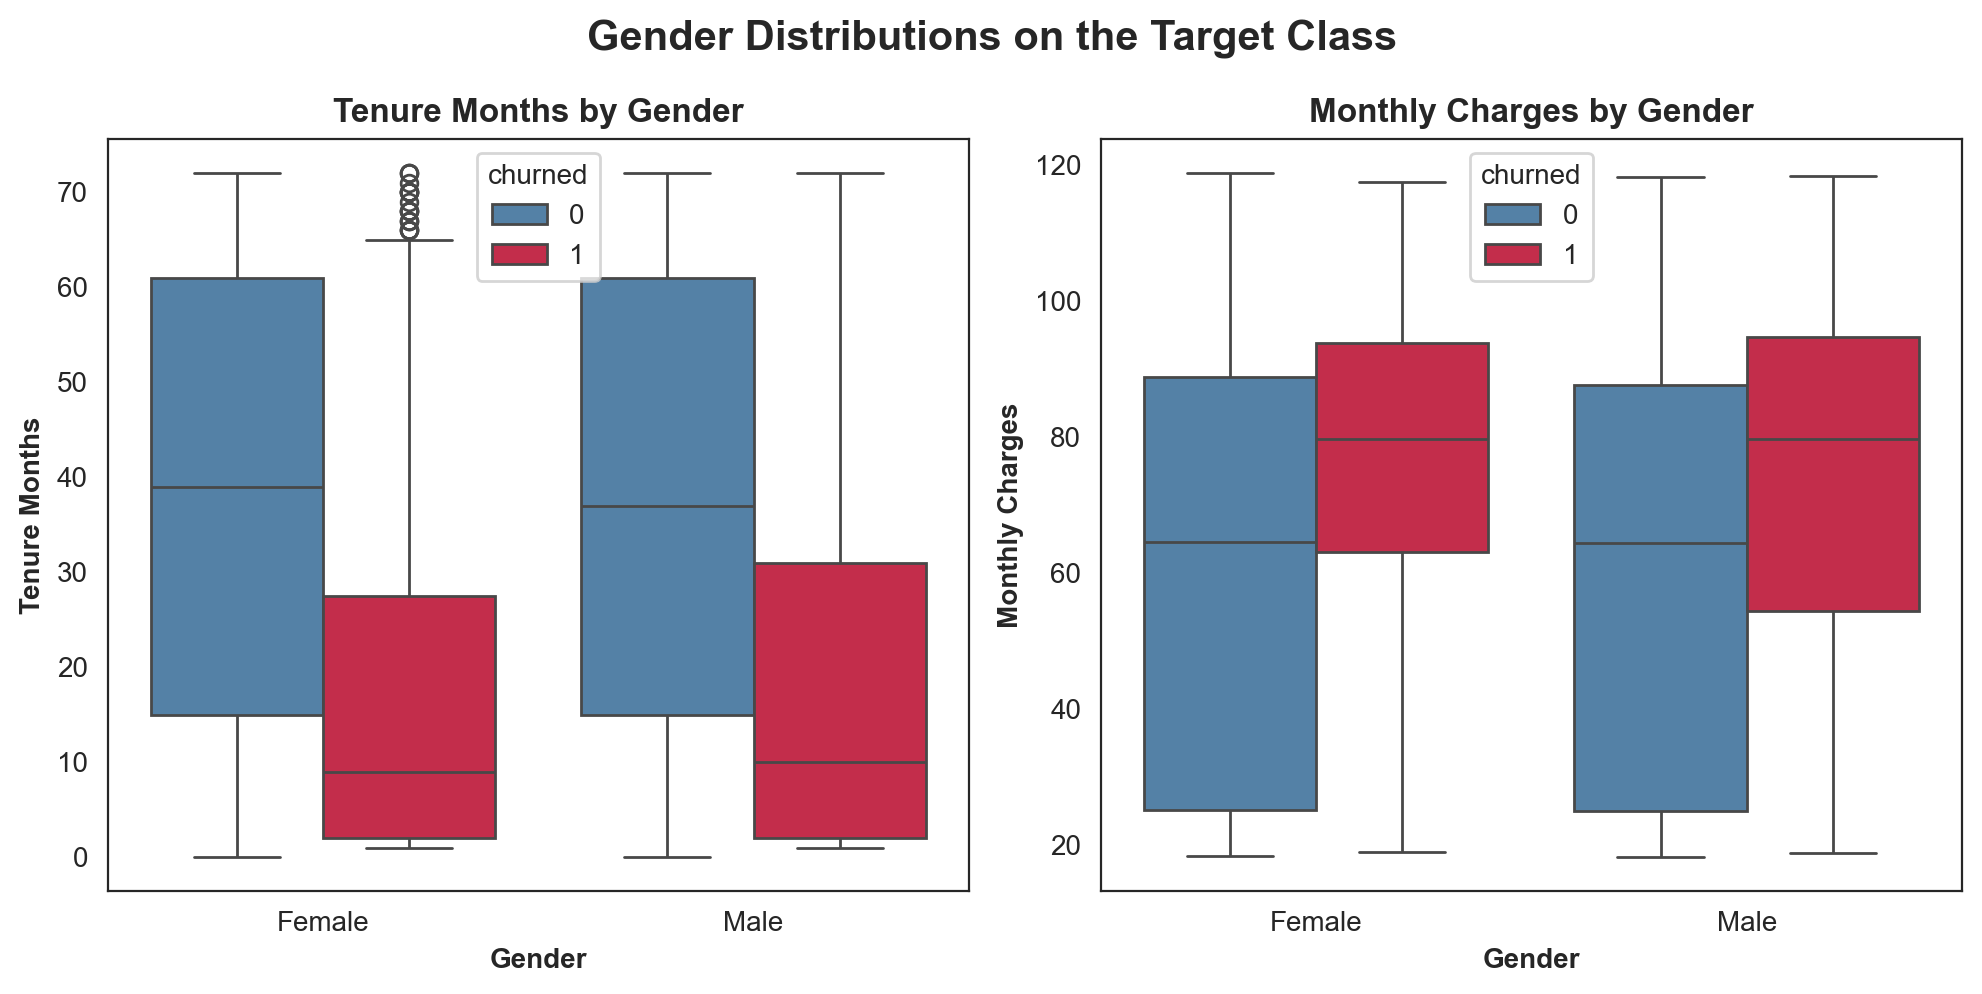

In [76]:
sns.set_style('white')

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (10,5))
plt.suptitle("Gender Distributions on the Target Class", fontsize = 15, fontweight = 'bold')
axs = axs.flatten()

for i, col in enumerate(['tenure_months', 'monthly_charges']):
    sns.boxplot(data = data, x = 'gender', y = col, 
                hue = 'churned', palette = ['steelblue', 'crimson'],
                ax = axs[i])
    axs[i].set_title(f"{inflection.titleize(col)} by Gender",
              fontsize = 12, fontweight = 'bold')
    axs[i].set_xlabel("Gender", fontweight = 'bold')
    axs[i].set_ylabel(f"{inflection.titleize(col)}", fontweight = 'bold')

plt.tight_layout()
plt.show()

It does appear that females have an ever so slightly shorter `tenure` in those that leave, but practically no difference in active clients. As for `monthly charges`, we can see that males do have a lower 25 percentile, but their medians are very similar. We could do further hypothesis testing to compare the means, but I do not believe this to be necessary. We can safely **drop `Gender`.**

[Back to Contents](#contents)

## 5.8 Conclusion
<a id='eda_summ'></a>

Below is a summary of all findings during EDA.

### 1. Numerical Features
- **General Observations**
    - Most clients opt for less expensive plans.
    - Clients with no additional internet packages outnumber those with a single internet package.
    - `Tenure` follows a "U-shaped" distribution: clients churn early or commit to longer terms.
- **Target Class Analysis:**
    - Churned clients pay higher **monthly charges** but accumulate lower **total charges** (indicating early churn).
    - Median tenure for active clients is 3 years; **75%** of churned clients leave within 2 years.
    - Active and churned clients have similar distributions for the number of internet packages.
- **New Feature:**
    - Created **Charge Groups** based on `monthly_charges`: 0-40, 40-70, 70-110, and 110+ to better segment monthly charges.

### 2. Categorical Features
- **Marketing Recommendations:**
    - Focus on clients who are:
      - Subscribed **monthly**
      - Paying via **Electronic Check**
      - Not on **auto-payment**
      - Subscribed to **Streaming TV & Movies** packages
      - Highest churn occurs in Quarters 3 & 4, mostly 4

### 3. Target Class 
- Active clients outnumber churned clients by a ratio greater than 2:1
- We plan to address this imbalance through weight adjustments and then through SMOTE if needed.

### 4. Client Behavior Insights
- **Service Type:**
    - Most clients are subscribed to both internet and landline services.
    - Clients subscribed to internet services are higher churn risks, likely indicating dissatisfaction.
    - Churn liklihood decreases with **4+ additional packages**. Providing incentivization could improve retention.
- **Inflow/Outflow:**
    - Departure data is limited to the last **4 months**.
    - Subscriptions show no clear patterns, but client departures **double** subscriptions. 

### 5. Correlations
- `service_type`, `tenure`, `payment_method`, and `charge_group` are our top predictors with high correlation and association to the target.
- The engineered feature `charge_group`, outperforms the original `monthly_charges` feature.
- `gender` has no association with any categorical or relevant numerical features and can be removed.
- `multiple_lines` has a weak association with the target but remains due to its links with other strong predictors.
- Internet service packages have strong associations with each other.
- `auto_payment` and `payment_method` have a perfect association.
    - Redundancy evaluation is tricky as they each have better associations with certain features than the other.
- `quarter` has a weak association with other features but moderate strength with the target. 

### 6. Final Feature Decisions
- `gender` will be dropped due to lack of association.
- `auto_payment` and `payment_method` will be retained despite perfect association for potential model improvement.
- All engineered features will remain for model tranining.

[Back to Contents](#contents)

# 6. Model Development

## minor notes - not relevant to final notebook
Are new clients relevant? I think no. _Fahad: Leave them in_

Converting the binaries to 0/1 and how that affects a Nueral Network.

Paperless billing relevance. _Fahad: Leave it in._

total charges adding. 

improvements: age, geographical data (more personal data), company review data

# Appendix A: Saving Models
<a id='apx_A'></a>

---
Run the code below when you need to resave the models or add new ones to save. 

# Appendix B: PreProcessing Notes
<a id='apx_B'></a>

---
Below are the documented issues discovered during data exploration to be used for preprocessing. 

## Contract Notes

- The column labels are currently in pascal case and need to be converted to snake case.
- The `EndDate` column contains non-date values and therefore need to be replaced with a more appropriate value.
    - We will first replace the `No` values with `None` and then **convert to datetime**.
    - `BeginDate` also needs to be converted to datetime.
- `TotalCharges` contains non-numerics (single-space values) that need to be removed.
    - The IDs to remove are stored in ids_to_remove
    - The column then needs to be **converted to float64**
    - Add `MonthlyCharges` to `TotalCharges` to obtain the proper totals.

## Internet Notes
- Convert column labels from pascal case to snake case.
- Convert binary fields to numeric.
    - Convert **datatype to int64**.

## Personal Notes
- Convert `Partner` and `Dependents` to binary numeric fields and **convert to int64**.
- Convert column labels from pascal to snake case. 

## Phone
- Convert `MultipleLines` to binary numeric and **convert to int64**.
- Convert column labels from pascal to snake case.

## Feature Engineering Possibilities
- [x] Tenure for years, months, and days
- [x] Creating a dedicated `active` or `churned` column --> binary flag indicating if the client is active or has churned
- [x] Creating a categorical column describing the type of services subscribed (_landline, internet, or both_)
- [x] Creating a numerical column listing how many internet services the client is subscribed to
- [x] Creating a new column converting `payment_method` to either "manual" or "automatic"
- [x] Creating a new column converting `begin_date` to seasonal values?

# Appendix C: Work Plan
<a id='the_plan'></a>

---

## Understanding the Project's Objectives and its Data (Frame the Problem)
- What is the company trying to solve?
- Why is the company trying to solve it?
- What are the objectives for the model to achieve?
    - _AUC-ROC  $\geq$ 0.85_

## Imported Modules
- Provide a section of all imported modules as in past projects.

## Data Overview
- Description of dataset and how they relate to each other.
- For each column:
  - Name
  - Type of Data
  - % Missing
  - Noisiness
  - Relevance for the Task
  - Type of Distribution
- **Observe**:
  - Sample rows, shape, duplicates, nulls, dtypes, and descriptive statistics (all).
- **Document Discovered Issues or Concerns for Preprocessing**:
  - Implicit erroneous values, particularly in categorical variables.
  - Opportunities for decomposing or creating features.
- Form Conclusion/Summary for preprocessing

## Preprocessing
- Merge the datasets on **CustomerID**
- Execute all fixes discovered during exploration
- Perform Feature Engineering if possible

---

# Exploratory Data Analysis (EDA)

## Numerical Features
- Visualize distributions:
  - Histograms
  - Boxplots
- Compare distributions between churned vs. retained customers.

## Categorical Features
- Visualize distributions:
  - Bar charts
  - Compare distributinos between churned vs. retained customers - _using filled charts_.

## Target Class Distributions
- Is there an imbalance in the target class?

## Questions to Ask (Visuals to Provide):
- Are there noticeable differences in monthly payments between classes?
- Are there groups of clients that marketing can target based on monthly charges?
- What percentage of customers use each service type?
- Are there patterns in start and end dates?
    - When were customers joining and leaving?
    - What quarters were the most popular?
- Which features should be prioritized for comparison with the target class?

## Correlation Analysis
- Create a correlation matrix to observe relationships between numerical features and the target variable.

## Summary
- Summarize findings and key insights.

---

# Modeling

## Model Training
- Reuse functions and processes from previous projects where applicable - attempt to make improvements
    - Possibly create function for preparing and training models
    - Create function for evaluating models
    - Create function for loading and saving models - _saves time_
- Drop any determined unnecessary features lingering from EDA
- Split data into features and target
- Apply one-hot encoding and scaling - _use standard scaler_
- Address class imbalance through most approrpiate means
- Split data into training, validation, and test sets (80:10:10)
- Train and evaluate the various models

## Models to Use
1. Dummy Classifier
2. Tree-based: Decision Tree or Random Forest
3. Logistic Regression (_linear would perform poorly_)
4. AdaBoost
5. CatBoost
6. XGBoost
7. LightGBM
8. HistGradientBoosting (new model)
9. Neural Network (self-challenge)
10. Stacking Ensemble (self-challenge, new model)
    - **_blend boosting and log-reg_**

## Model Evaluation
- Metrics:
  - **Primary**: AUC-ROC (goal: 0.85 or higher, aim for 0.88).
  - **Secondary**: Accuracy.
- Goals:
  - **Overfitting** is a concern so we will need to prioritize **regularization** more so than previous projects.

## Final Model Selection
- Select the model with the best performance on the validation set.
- Justify the choice based on evaluation metrics.

---

# Questions to Ask for Team Lead

1. How should class imbalance be handled? (e.g., oversampling, undersampling, class weights)
2. How will this solution be used by the company?
3. Are there any existing solutions to compare the performance against?
    - Are there any recommendations on specific models that have been successful in similar prediction tasks?
    - Can I reuse any experience or tools?
   > **Yes, I have worked on a churn problem before. In addition, I can reuse many functions and processes from previous projects to aid me in code development and analysis.** 
5. Are there specific features that need more in-depth analysis?
6. Which features should be prioritized during the analysis phase?
7. How would this problem be solved manually?
8. Are there any observable patterns that encourage customer retention?
9. What preferences are there for handling missing values?

---

# Additional Notes

- Revisit the objectives and assumptions after EDA.
- **Document any observations or challenges encountered during the analysis and modeling phases.**


# Appendix D: Challenges Faced
<a id='challenges'></a>

---

1. **Setting up Tensorflow Environment**
    - spent 2.5 hours initially trying to get it installed. Failed.
    - Created new conda environment and eventually got it to work with a stable and productive python env for the project.
        -  Added skopt for bayesian optimization and this broke the whole environment. Had to start over as the env. wasn't backed up - didn't know I could, but now I do and skopt is added and the environment is backed up.
3. **Begin_date was same as end_date -- typo in code**
4. **Odd number of Mosaic**
5. **Target class imbalance - selecting a method and evaluating it in a quick time frame - deadline pressure.**
    - Begin with class weight adjustments. Assigning higher weights to the minority class to make the model more sensitive to it. With our robust parameter tuning this project, this method should work well.
    - Use SMOTE to oversample the minority and under sample the majority.
6. **Building Custom Matrix for Categorical Variables**
    - Used Cramer's V 